<b>Data mining project - 2020/21</b><br>
<b>Authors</b>: [Alexandra Bradan](https://github.com/alexandrabradan), [Alice Graziani](https://github.com/alicegraziani25) and [Eleonora Cocciu](https://github.com/eleonoracocciu)<br>
<b>Python version</b>: 3.x<br>
<b>Last update: 21/05/2021<b>

In [1]:
# system library
import os
import sys
import json
import pickle
import isoweek
import datetime
import calendar
import operator
from tqdm.notebook import tqdm
from datetime import date, timedelta
from dateutil.relativedelta import relativedelta

# useful libraries
import math
import operator
import itertools
import statistics
import collections
from collections import Counter
from collections import OrderedDict

# pandas
import pandas as pd

# numpy
import numpy as np
from numpy import std
from numpy import mean
from numpy import percentile

# visualisarion
import pydotplus
import seaborn as sns
from matplotlib import colors
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from IPython.display import Image

# sklearn
from sklearn.pipeline import FeatureUnion
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import classification_report, confusion_matrix

# dimensional reducers
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFE
from sklearn.feature_selection import RFECV
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif  # classification
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression  # regression

# scalers
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.preprocessing import OneHotEncoder

# performance visualisation 
from sklearn import tree
from scikitplot.metrics import plot_roc
from scikitplot.metrics import plot_precision_recall
from scikitplot.metrics import plot_cumulative_gain
from scikitplot.metrics import plot_lift_curve
from sklearn.model_selection import learning_curve
from mlxtend.plotting import plot_decision_regions
from yellowbrick.model_selection import LearningCurve

# svm
from sklearn.svm import SVC
from sklearn.svm import LinearSVC

plt.rcParams["patch.force_edgecolor"] = True
%matplotlib inline

from yellowbrick.style import set_palette
set_palette('bold')

In [2]:
ts_column_name = 'track_listens'

<h6> Datasets loading </h6>

In [3]:
filename = "TS_album_type_" + ts_column_name + ".csv"
df = pd.read_csv('../../data/fma_metadata/' + filename, index_col=0)
tracks = pd.read_csv('../../data/fma_metadata/tracks.csv', index_col=0, header=[0, 1])
df_group_20 = pd.read_csv('../../data/fma_metadata/group_20_fma.csv', index_col=0)
original_df_group_20 = df_group_20.copy()
print(df.shape)

(70224, 3)


In [4]:
# reconstruct 'track_date_created' and 'original_album_type' columns
date_created_column = pd.to_datetime(tracks[('track', 'date_created')], format='%Y%m', errors='ignore').astype('datetime64[ns]')
original_album_type_column = tracks[('album', 'type')]

track_date_created_year_index = df_group_20.columns.get_loc("track_date_created_year")
track_date_created_season_index = df_group_20.columns.get_loc("track_date_created_season")
album_type_index = df_group_20.columns.get_loc("album_type")

df_group_20.insert(track_date_created_year_index, 'track_date_created', date_created_column)
df_group_20.insert(album_type_index, 'original_album_type', original_album_type_column)
df_group_20['original_album_type'] = df_group_20['original_album_type'].fillna('Album')
wrong_fillna = df_group_20[(df_group_20['original_album_type'] == 'Album') & 
                           (df_group_20['album_type'] == 'Live Recording')]
for idx in wrong_fillna.index:
    df_group_20.at[idx, 'original_album_type'] = 'Radio Program'
del df_group_20["track_date_created_year"]
del df_group_20["track_date_created_season"]

In [5]:
# approximated marginal weeks
first_year = df_group_20[df_group_20['track_date_created'].dt.year == 2008] 
last_year = df_group_20[df_group_20['track_date_created'].dt.year == 2017]
first_year_keep = df_group_20[(df_group_20['track_date_created'].dt.year == 2008) & 
                    (df_group_20['track_date_created'].dt.month == 12) & 
                    (df_group_20['track_date_created'].dt.day >= 29)] 
last_year_keep = df_group_20[(df_group_20['track_date_created'].dt.year == 2017) & 
                    (df_group_20['track_date_created'].dt.month == 1) & 
                    (df_group_20['track_date_created'].dt.day == 1)]
to_keep = set(list(first_year_keep.index) + list(last_year_keep.index))

# removing marginal weeks, months and years
to_drop = set(list(first_year.index) + list(last_year.index)).difference(to_keep)
df_group_20.drop(to_drop, axis=0, inplace=True)
df_group_20.shape

(96910, 44)

In [6]:
# retrieve Studio and Live DataFrames
studio_key = 'Studio_Recording_' + ts_column_name
live_key = 'Live_Recording_' + ts_column_name

studio_ts = df[studio_key]
live_ts = df[live_key]

# converting the index as date
studio_ts.index = pd.to_datetime(studio_ts.index)
live_ts.index = pd.to_datetime(live_ts.index)

<h6> Dataset statistics </h6>

In [7]:
df['Studio_Recording_' + ts_column_name].describe()

count    7.022400e+04
mean     3.184690e+03
std      2.416287e+04
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      2.067525e+06
Name: Studio_Recording_track_listens, dtype: float64

In [8]:
df['Live_Recording_' + ts_column_name].describe()

count     70224.000000
mean        159.081311
std        2163.663648
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max      240814.000000
Name: Live_Recording_track_listens, dtype: float64

<h2>Visualize Raw Data</h2>

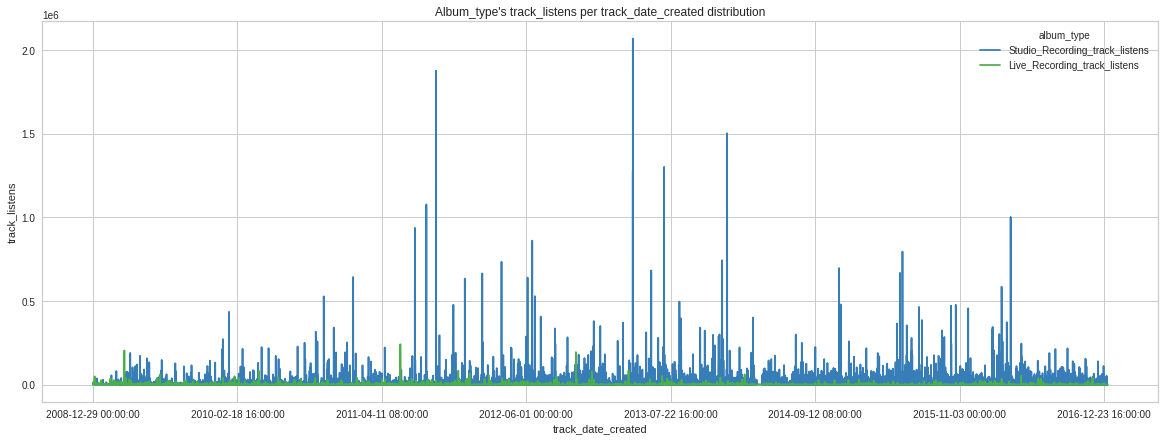

In [9]:
df[['Studio_Recording_%s' % ts_column_name, 'Live_Recording_%s' % ts_column_name]].plot(figsize=(20,7))
plt.xlabel('track_date_created')
plt.ylabel(ts_column_name)
plt.legend(title='album_type')
plt.title("Album_type's %s per track_date_created distribution" % ts_column_name)
plt.show()

<h2>Compute Matrix Profiles</h2>

Here we compute Matrix Profiles over varying window sizes:

- 12 hours (1/2 of a day);
- 24 hours (1 day);
- 168 hours (7 days);
- 360 hours (15 days);
- 720 hours (30 days);
- 2190 hours (90 days);
- 4380 hours (180 days);
- 8760 hours (360 days).

In [10]:
from matrixprofile import *

In [11]:
def get_stomp_matrix_profile(ts, w, name):
    """
        'stomp' is the first exact algorithm to compute the Matrix Profile.
        Other options are 'mpx','prescrimp' and 'scrimp_plus_plus'.
    """
    mp, mpi = matrixProfile.stomp(ts, w)
    
    fig, ax = plt.subplots(figsize=(8, 5))
    plt.plot(mp)
    ax.ticklabel_format(axis='y', useOffset=False, style='plain')  # prevent scientific notation
    plt.xlabel("incremental datetimes")
    plt.ylabel("distance")
    plt.title(str(name) + "'s Matrix Profile" + " - w = " + str(w))
    plt.show()
    return mp, mpi

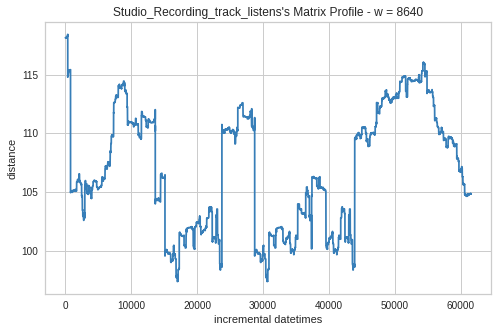

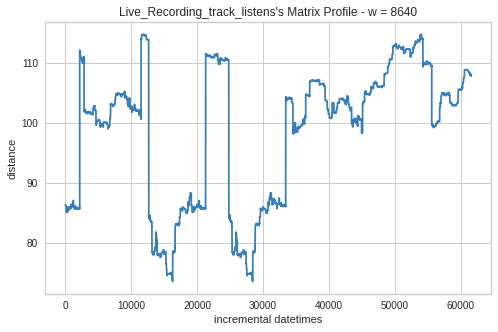

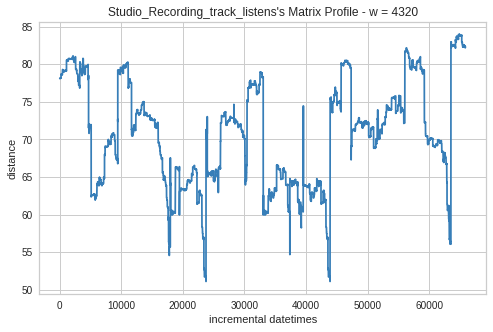

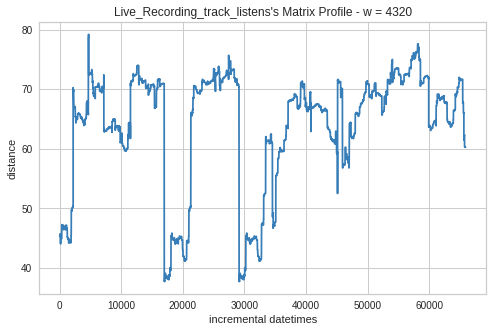

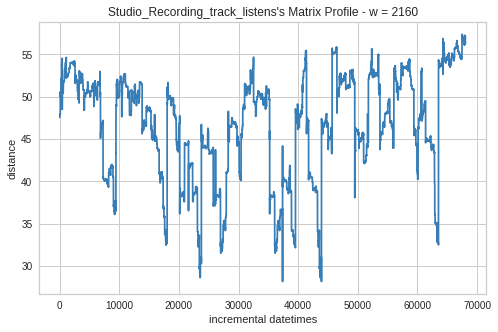

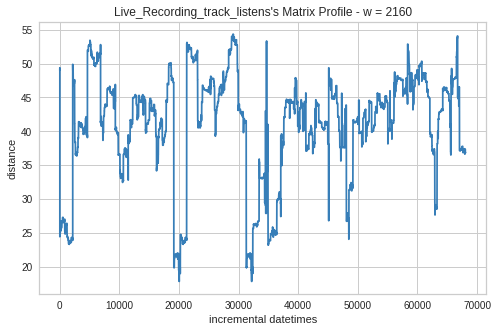

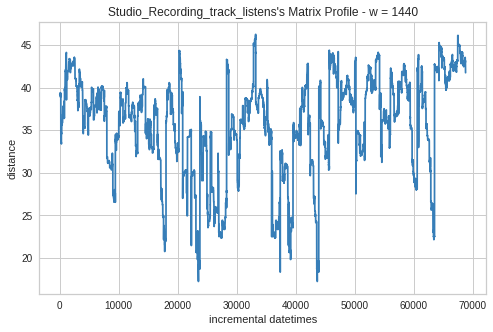

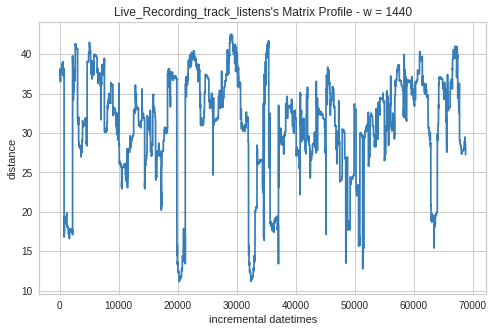

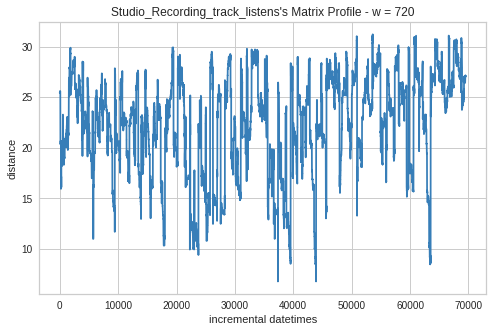

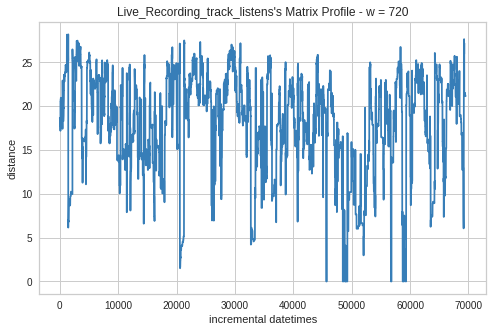

In [12]:
windows = [
    ('1 Year', 30 * 24 * 12),
    ('180 Days', 30 * 24 * 6),
    ('90 Days', 30 * 24 * 3),
    ('60 Days', 30 * 24 * 2),
    ('30 Days', 30 * 24),
    ]
"""
('15 Days', 15 * 24)
('7 Days', 7 * 24),
('24 Hours', 24),
('12 Hours', 12)
]"""

studio_profiles = {}
live_profiles = {}
for label, window_size in tqdm(windows):
    
    studio_mp, studio_mpi = get_stomp_matrix_profile(studio_ts.values, window_size, studio_key)
    live_mp, live_mpi = get_stomp_matrix_profile(live_ts.values, window_size, live_key)

    key = '%s' % str(label)
    studio_profiles[key] = studio_mp, studio_mpi 
    live_profiles[key] =  live_mp, live_mpi

<b><font color="red">We are impossibilited to compute smaller windows due to the following error:
    
    RuntimeWarning: divide by zero encountered in true_divide
    res = 2*m*(1-(dot-m*mean*q_mean)/(m*std*q_std))
    
</font></b>

<h2> Motif Discovery </h2>

In [13]:
def plot_motifs(ts, mo, w, name, motif_or_anomaly_flag):
    
    fig, ax = plt.subplots(figsize=(8, 5))
    ts.plot(ax=ax)
    colors = ['darkorange', 'green', 'black', 'gold', 'blue'][:5]
    for m, c in zip(mo, colors):
        if motif_or_anomaly_flag == "motif":  # mo = list of lists
            for i in m:
                m_shape = ts[i:i+w]
                m_shape.plot(color=c, lw=3, ax=ax)
        else:  # mo = list
            m_shape = ts[m:m+w]
            m_shape.plot(color=c, lw=3, ax=ax)

    ax.ticklabel_format(axis='y', useOffset=False, style='plain')  # prevent scientific notation
    plt.xlabel("incremental datetimes")
    plt.ylabel(ts_column_name)
    plural_motif_or_anomaly_flag = motif_or_anomaly_flag
    if motif_or_anomaly_flag == "anomaly":
        plural_motif_or_anomaly_flag = "anomalie"
    plt.title(str(name) + "'s %ss"% plural_motif_or_anomaly_flag + " - w = " + str(w))
    plt.show()

In [14]:
def get_start_or_end_data_to_plot(dates_list):
    # x initialisation
    x_years = list(range(2009, 2017))
    x_months = list(range(1, 13))
    x_days = ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]
    x_hours = list(range(0, 24))
    
    # y initialisation
    y_years = [0]*len(x_years)
    y_months = [0]*len(x_months)
    y_days = [0]*len(x_days)
    y_hours = [0]*len(x_hours)
    
    for d in dates_list:
        y, m, d, h = d.year, d.month, d.strftime("%A")[:3], d.hour
        
        if y == 2008:
            y = 2009
        elif y == 2017:
            y = 2016
        
        y_index = x_years.index(y)
        m_index = x_months.index(m)
        d_index = x_days.index(d)
        h_index = x_hours.index(h)
        
        check_list = [y_index, m_index, d_index, h_index]
        if -1 in check_list:
            print("wrong indeces=%s" % [y_index, m_index, d_index, h_index])
            sys.exit(-1)
            
        y_years[y_index] += 1
        y_months[m_index] += 1
        y_days[d_index] += 1
        y_hours[h_index] += 1
        
    return x_years, x_months, x_days, x_hours, y_years, y_months, y_days, y_hours

In [15]:
def plot_start_or_end(dates_list, start_or_end_flag, w, color, mo_num, name, plural_motif_or_anomaly_flag):
    fig = plt.subplots(figsize=(20, 2.5))
    fig_dims = (1, 4)
    
    x_years, x_months, x_days, x_hours, y_years, y_months, y_days, y_hours = \
                                                                    get_start_or_end_data_to_plot(dates_list)

    plt.suptitle("%s %s %s %s insigth (repeats %s times)" % (name.title(), plural_motif_or_anomaly_flag,\
                                mo_num, start_or_end_flag, sum(y_years)) + " - w = " + str(w), fontsize='x-large')
    ax = plt.subplot2grid(fig_dims, (0, 0))
    plt.bar(x_years, y_years, color=color)
    plt.xticks(x_years)
    plt.xlabel("years")
    plt.ylabel("count")
    
    ax = plt.subplot2grid(fig_dims, (0, 1))
    plt.bar(x_months, y_months, color=color)
    plt.xticks(x_months)
    plt.xlabel("months")
    plt.ylabel("count")
    
    ax = plt.subplot2grid(fig_dims, (0, 2))
    plt.bar(x_days, y_days, color=color)
    plt.xlabel("days")
    plt.ylabel("count")
    
    ax = plt.subplot2grid(fig_dims, (0, 3))
    plt.bar(x_hours, y_hours, color=color)
    plt.xticks(np.arange(0, 24, 2))
    plt.xlabel("hours")
    plt.ylabel("count")

    plt.show()

In [16]:
def plot_single_motifs(ts, mo, w, name, motif_or_anomaly_flag):
    colors = ['darkorange', 'green', 'black', 'gold', 'blue'][:5]
    mo_num = 0
    for m, c in zip(mo, colors):
        starts, ends = [], []
        fig, ax = plt.subplots(figsize=(8, 5))
        ts.plot(ax=ax)
        if motif_or_anomaly_flag == "motif":
            for i in m:
                m_shape = ts[i:i+w]
                m_shape.plot(color=c, lw=3, ax=ax)
                
                start = m_shape.index.min()
                end = m_shape.index.max()
                starts.append(start)
                ends.append(end)
        else:
            m_shape = ts[m:m+w]
            m_shape.plot(color=c, lw=3, ax=ax)
            
            start = m_shape.index.min()
            end = m_shape.index.max()
            starts.append(start)
            ends.append(end)
            
        plt.xlabel("incremental datetimes")
        plt.ylabel(ts_column_name)
        plural_motif_or_anomaly_flag = motif_or_anomaly_flag
        plt.title(str(name) + "'s %s %s" % (motif_or_anomaly_flag, colors.index(c)) + " - w = " + str(w))
        ax.ticklabel_format(axis='y', useOffset=False, style='plain')  # prevent scientific notation
        plt.show()
        
        # print("MO_NUM=%s" % mo_num, "TOT_CURR_MOTIFS=%s" % len(m), sep='\t')
        plot_start_or_end(starts, "start", w, c, mo_num, name, plural_motif_or_anomaly_flag)
        plot_start_or_end(ends, "end", w, c, mo_num, name, plural_motif_or_anomaly_flag)
        mo_num += 1
        
        print()
        print("-----------------------------------------------------------------------------------------------------")
        print()

In [17]:
def plot_agglomerated_motifs(studio_dict, live_dict, motif_or_anomaly_flag):
    for label, window_size in windows:
        key = '%s' % str(label)
        if motif_or_anomaly_flag == "motif":
            studio_mo  = studio_dict[key][0]
            live_mo = live_dict[key][0]
        elif motif_or_anomaly_flag == "anomaly":
            studio_mo  = studio_dict[key]
            live_mo = live_dict[key]
        else:
            print("wrong motif_or_anomaly_flag=%s" % motif_or_anomaly_flag)
            sys.exit(-1)

        plot_motifs(studio_ts, studio_mo, window_size, studio_key, motif_or_anomaly_flag)
        plot_motifs(live_ts, live_mo, window_size, live_key, motif_or_anomaly_flag)

In [18]:
def plot_individual_motifs(studio_dict, live_dict, motif_or_anomaly_flag, studio_or_live_flag):
    for label, window_size in windows:
        key = '%s' % str(label)
        if motif_or_anomaly_flag == "motif":
            studio_mo  = studio_dict[key][0]
            live_mo = live_dict[key][0]
        elif motif_or_anomaly_flag == "anomaly":
            studio_mo  = studio_dict[key]
            live_mo = live_dict[key]
        else:
            print("wrong motif_or_anomaly_flag=%s" % motif_or_anomaly_flag)
            sys.exit(-1)

        if studio_or_live_flag == "studio":
            plot_single_motifs(studio_ts, studio_mo, window_size, studio_key, motif_or_anomaly_flag)
        elif studio_or_live_flag == "live":
            plot_single_motifs(live_ts, live_mo, window_size, live_key, motif_or_anomaly_flag)

In [19]:
def motifs_discovery():
    studio_motifs = {}
    live_motifs = {}
    for label, window_size in windows:

        key = '%s' % str(label)
        studio_mp, studio_mpi  = studio_profiles[key][0], studio_profiles[key][1]
        live_mp, live_mpi = live_profiles[key][0], live_profiles[key][1]

        ex_zone = window_size
        studio_mo, studio_mod  = motifs.motifs(studio_ts.values, (studio_mp, studio_mpi), 
                                               max_motifs=5, ex_zone=ex_zone)
        live_mo, live_mod  = motifs.motifs(live_ts.values, (live_mp, live_mpi), 
                                           max_motifs=5, ex_zone=ex_zone)

        studio_motifs[key] = studio_mo, studio_mod 
        live_motifs[key] =  live_mo, live_mod
        
    return studio_motifs, live_motifs

<h6> Retrieve top 5 motifs </h6>

In [20]:
studio_motifs, live_motifs = motifs_discovery()

<h6>Plot agglomerated motifs upon original TS</h6<

In [21]:
# plot_agglomerated_motifs(studio_motifs, live_motifs, "motif")

<h6>Plot individual Studio motifs upon original TS</h6>

In [22]:
# plot_individual_motifs(studio_motifs, live_motifs, "motif", "studio")

In [23]:
# plot_individual_motifs(studio_motifs, live_motifs, "motif", "live")

<h6>Motifs zoom-in </h6>

In [24]:
def print_motifs_insight(ts, mo, w, name, plot_flag, motif_or_anomaly_flag):
    mo_num = 0
    for motif in mo:
        print("w=%s - %s - motif_num=%s" % (w, name, mo_num))
        for i in motif:
            ts_shape = ts.index[i:i+w]
            start = ts_shape.min()
            end = ts_shape.max()
            start_weekday = calendar.day_name[start.weekday()]
            end_weekday = calendar.day_name[end.weekday()]
            print("start=%s %s" % (start_weekday, start), "end=%s %s" % (end_weekday, end), sep='\t')
            if plot_flag:
                m_shape = ts[i:i+w]
                
                fig, ax = plt.subplots(figsize=(8, 5))
                m_shape.plot()
                plt.xticks(rotation=90)
                ax.ticklabel_format(axis='y', useOffset=False, style='plain')  # prevent scientific notation
                plt.xlabel("incremental datetimes")
                plt.ylabel(ts_column_name)
                plt.title(str(name) + "'s %s %s" % (motif_or_anomaly_flag, mo_num) + " - w = " + str(w))
                plt.show()
        mo_num += 1
            
        print()
        print("-----------------------------------------------------------------------------------------------------")
        print()

In [25]:
def motifs_insight(interesting_windows, studio_or_live_flag, plot_flag, motif_or_anomaly_flag):
    for label, window_size in interesting_windows:
        
        key = '%s' % str(label)
        studio_mo, studio_mod  = studio_motifs[key][0], studio_motifs[key][1]
        live_mo, live_mod = live_motifs[key][0], live_motifs[key][1]

        if studio_or_live_flag == "studio":
            print_motifs_insight(studio_ts, studio_mo, window_size, studio_key, plot_flag, motif_or_anomaly_flag)
        elif studio_or_live_flag == "live":
            print_motifs_insight(live_ts, live_mo, window_size, live_key, plot_flag, motif_or_anomaly_flag)
        else:
            print("wrong studio_or_live_flag=%s" % studio_or_live_flag)
            sys.exit(-1)

In [26]:
def plot_peak(peak_dates, peaks_values, peaks_w_positions, w, color, mo_num, name,
                                                                              plural_motif_or_anomaly_flag):
    fig = plt.subplots(figsize=(20, 3))
    fig_dims = (1, 6)
    
    x_years, x_months, x_days, x_hours, y_years, y_months, y_days, y_hours = \
                                                                    get_start_or_end_data_to_plot(peak_dates)
    counter = Counter(peaks_values)
    sorted_counter = dict(sorted(counter.items(), key=operator.itemgetter(1)))
    x_values = list(sorted_counter.keys())
    y_values = list(sorted_counter.values())
    
    counter = Counter(peaks_w_positions)
    sorted_counter = dict(sorted(counter.items(), key=operator.itemgetter(1)))
    x_w_positions = list(sorted_counter.keys())
    y_w_positions = list(sorted_counter.values())
    

    plt.suptitle("%s %s %s %s insigth (repeats %s times)" % (name.title(), plural_motif_or_anomaly_flag,\
                                str(mo_num), "peaks", sum(y_years)) + " - w = " + str(w), fontsize='x-large')
    ax = plt.subplot2grid(fig_dims, (0, 0))
    plt.bar(x_years, y_years, color=color)
    plt.xticks(x_years)
    plt.xlabel("years")
    plt.xticks(rotation=90)
    plt.ylabel("count")
    
    ax = plt.subplot2grid(fig_dims, (0, 1))
    plt.bar(x_months, y_months, color=color)
    plt.xticks(x_months)
    plt.xlabel("months")
    plt.ylabel("count")
    
    ax = plt.subplot2grid(fig_dims, (0, 2))
    plt.bar(x_days, y_days, color=color)
    plt.xlabel("days")
    plt.ylabel("count")
    
    ax = plt.subplot2grid(fig_dims, (0, 3))
    plt.bar(x_hours, y_hours, color=color)
    plt.xticks(np.arange(0, 24, 2))
    plt.xlabel("hours")
    plt.ylabel("count")
    
    ax = plt.subplot2grid(fig_dims, (0, 4))
    plt.bar(x_w_positions, y_w_positions, color=color)
    plt.xlabel("week positions in w")
    plt.ylabel("count")
    
    
    ax = plt.subplot2grid(fig_dims, (0, 5))
    plt.hist(x_values, color=color)
    plt.xlabel("peak values")
    plt.ylabel("count")

    plt.show()

In [27]:
def plot_peaks(ts, mo, w, name, motif_or_anomaly_flag):
    colors = ['darkorange', 'green', 'black', 'gold', 'blue'][:5]
    mo_num = 0
    for m, c in zip(mo, colors):
        peak_dates, peaks_values, peaks_w_positions = [], [], []
        # if motif_or_anomaly_flag == "motif":
        for i in m:
            m_shape = ts[i:i+w]

            max_value = m_shape.max()
            # if more than one peak, keep track only for the last
            max_values_index = list(np.where(m_shape == max_value)[0])[0]
            max_values_date = m_shape.index[max_values_index]
            peak_dates.append(max_values_date)
            peaks_values.append(max_value)

            start_week_number = int(m_shape.index.min().strftime("%V"))
            peak_week_number = int(max_values_date.strftime("%V"))

            if start_week_number > peak_week_number:
                plus_delta = 53 - start_week_number
                peak_week_number += plus_delta
                start_week_number = 0

            delta = peak_week_number - start_week_number
            peaks_w_positions.append(delta)
            
        """else:
            m_shape = ts[m:m+w]
            
            max_value = m_shape.max()
            
            print(m_shape, max_value)
            
            # if more than one peak, keep track only for the last
            max_values_index = list(np.where(m_shape == max_value)[0])[0]
            max_values_date = m_shape.index[max_values_index]
            peak_dates.append(max_values_date)
            peaks_values.append(max_value)

            start_week_number = int(m_shape.index.min().strftime("%V"))
            peak_week_number = int(max_values_date.strftime("%V"))

            if start_week_number > peak_week_number:
                plus_delta = 53 - start_week_number
                peak_week_number += plus_delta
                start_week_number = 0

            delta = peak_week_number - start_week_number
            peaks_w_positions.append(delta)"""
        
        # print("MO_NUM=%s" % mo_num, "TOT_CURR_MOTIFS=%s" % len(m), sep='\t')
        plural_motif_or_anomaly_flag = motif_or_anomaly_flag
        plot_peak(peak_dates, peaks_values, peaks_w_positions, w, c, mo_num, name, plural_motif_or_anomaly_flag)
        mo_num += 1
        
        print()
        print("-----------------------------------------------------------------------------------------------------")
        print()

In [28]:
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes 
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
import matplotlib.dates as mdates

def plot_zoom_in_motifs(ts, mo, w, name, locs, zoom, y2, motif_or_anomaly_flag, peak_flag):
    fig, ax = plt.subplots(figsize=(20, 10))
    ts.plot(ax=ax)

    num_motifs = 0
    colors = ['darkorange', 'green', 'black', 'gold', 'blue']

    # plot motifs on TS
    motifs_max_x = []
    for motif, color in zip(mo, colors):
        for i in motif:
            m_shape = ts[i:i+w]
            m_shape.plot(color=color, lw=3, ax=ax)
            
        # keep max ordinate for each first motif's index
        i = motif[0]
        m_shape = ts[i:i+w]
        motifs_max_x.append(m_shape.max())
    print("motifs_max_x", motifs_max_x)

    # plot zoom-in motifs
    for motif, color in zip(mo, colors):
        # x-range for the zoomed region
        x1 = motif[0]  # plot first motif's index
        x2 = x1 + w

        # select y-range for zoomed region
        y1 = 0
        # y2 = ts[x1:x1+w].max() 

        # Make the zoom-in plot:
        axins = zoomed_inset_axes(ax, zoom, loc=locs[num_motifs])   
        
        tmp_ts = ts.copy()
        x1_vis = x1 - 100
        x2_vis = x2 + 100
        # tmp_ts = tmp_ts[x1_vis:x2_vis]
        tmp_ts = tmp_ts[x1:x2]
        # tmp_ts.index = [idx.date() for idx in tmp_ts.index]
        tmp_ts.plot(color=color, ax=axins)
    
        # axins.set_xlim(x1, x2)
        axins.set_ylim(y1, y2)
        # plt.xticks(visible=False) 
        # plt.yticks(visible=False)
        x_axis = axins.axes.get_xaxis()
        x_axis.set_visible(False)
        
        axins.axes.yaxis.set_label_position("right")
        axins.axes.yaxis.tick_right()
        plt.xticks(rotation=90)  
        # plt.xlabel("")
        
        months = []
        start = ts.index[x1].date()
        end = ts.index[x2].date()
        start = start.strftime('%A')[:3] + " " + str(start)
        end = end.strftime('%A')[:3] + " " + str(end)
        if motif_or_anomaly_flag == "motif":
            plt.title("motif %s" % num_motifs + " (repeated %s times)" % len(motif) + \
                                        ",\n first motif: %s - %s" % (start, end), fontsize=15)
        else:
            plt.title("anomaly %s" % num_motifs + ",\n %s - %s" % (start, end), fontsize=15)
        mark_inset(ax, axins, loc1=2, loc2=4, fc="none", ec="0.5")
        plt.draw()
        
        num_motifs += 1

    ax.ticklabel_format(axis='y', useOffset=False, style='plain')  # prevent scientific notation
    ax.set_xlabel("incremental datetimes", fontsize=15)
    ax.set_ylabel(ts_column_name, fontsize=15)
    if motif_or_anomaly_flag == "motif":
        ax.set_title(str(name) + "'s motifs" + " - w = " + str(w) + " (first motif zoom-in y cut-off=%s)" % y2, 
                         fontsize=15, pad=50)
    else:
        ax.set_title(str(name) + "'s anomalies" + " - w = " + str(w) + " (anomalies zoom-in y cut-off=%s)" % y2, 
                         fontsize=15, pad=50)
    plt.show()
    
    # peaks insight
    if peak_flag:
        plot_peaks(ts, mo, w, name, motif_or_anomaly_flag)

<h6>Studio motifs zoom-in</h6>

motifs_max_x [434131]


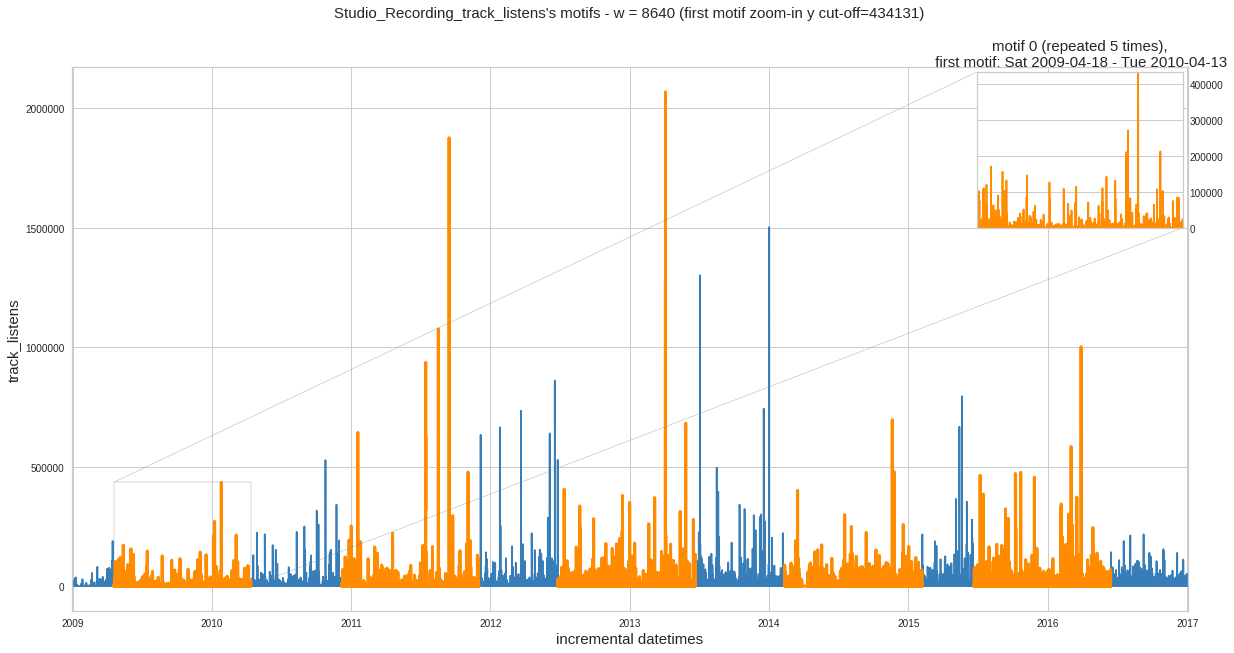

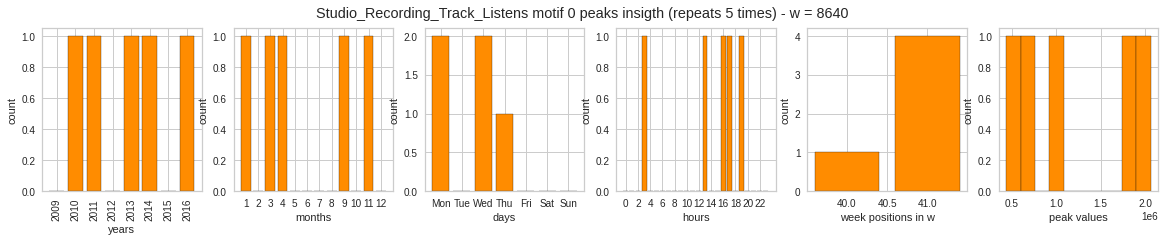


-----------------------------------------------------------------------------------------------------



In [34]:
ts = studio_ts
name = studio_key
key, w = windows[0][0], windows[0][1]
mo = studio_motifs[key][0]
plot_zoom_in_motifs(ts, mo, w, name, locs=[1], zoom=1.5, y2=434131, motif_or_anomaly_flag="motif", peak_flag=True)

motifs_max_x [171374]


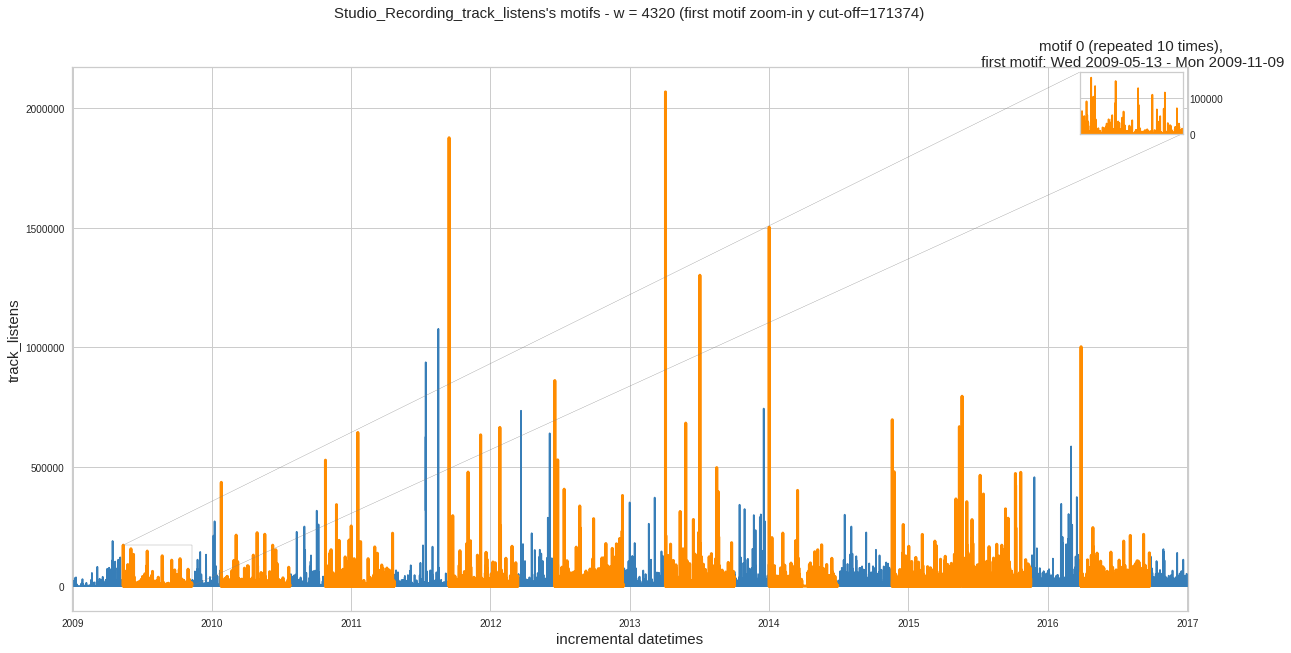

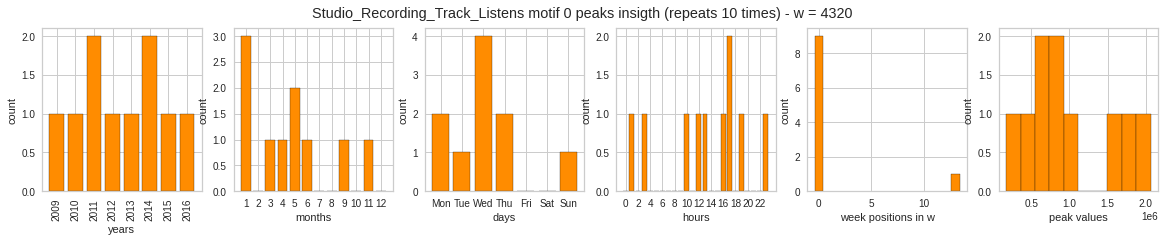


-----------------------------------------------------------------------------------------------------



In [35]:
ts = studio_ts
name = studio_key
key, w = windows[1][0], windows[1][1]
mo = studio_motifs[key][0]
plot_zoom_in_motifs(ts, mo, w, name, locs=[1], zoom=1.5, y2=171374, motif_or_anomaly_flag="motif", peak_flag=True)

motifs_max_x [188690, 80573]


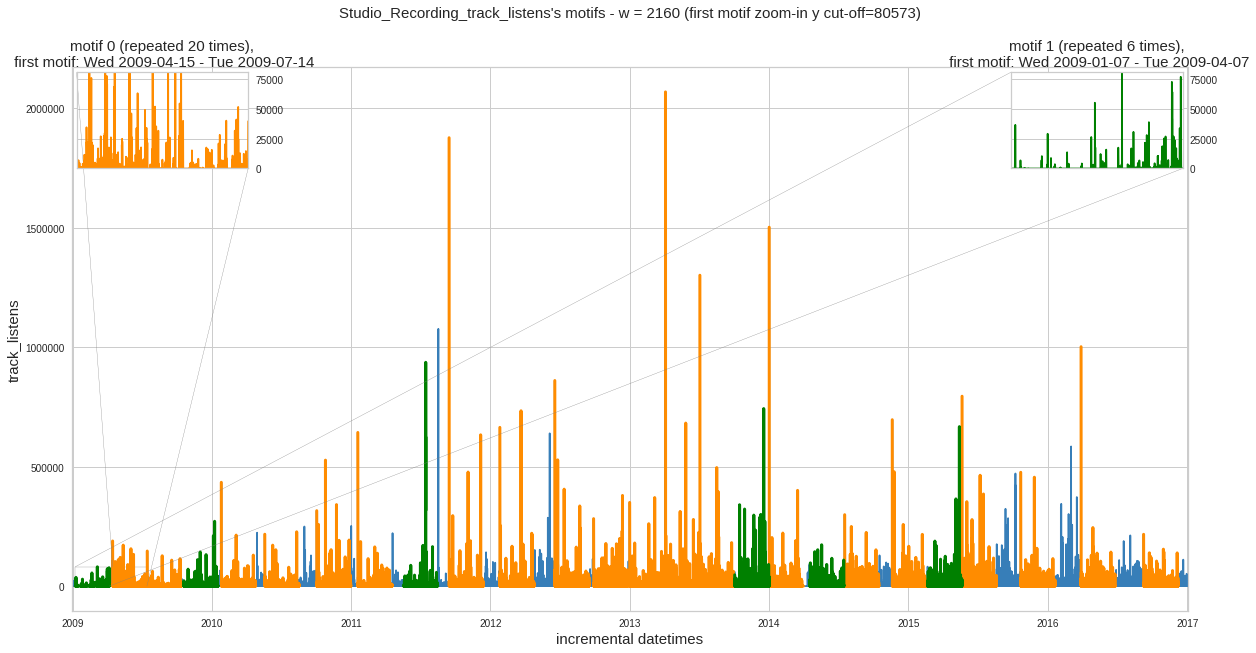

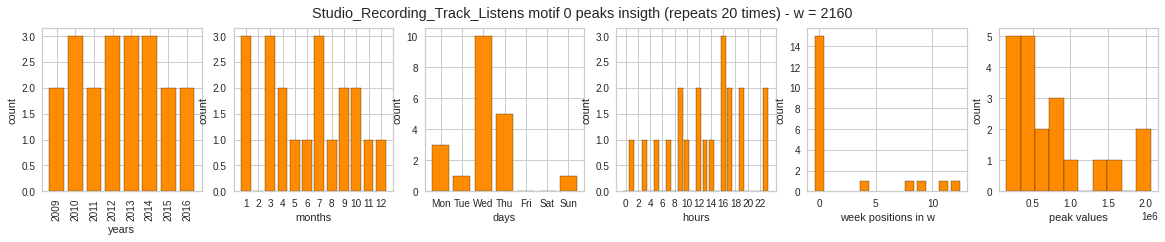


-----------------------------------------------------------------------------------------------------



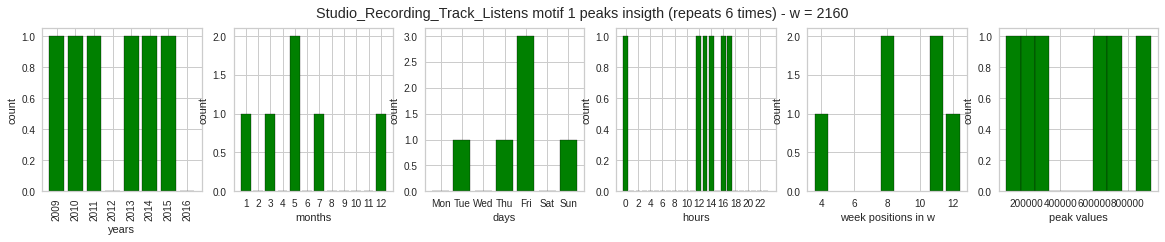


-----------------------------------------------------------------------------------------------------



In [39]:
ts = studio_ts
name = studio_key
key, w = windows[2][0], windows[2][1]
mo = studio_motifs[key][0]
plot_zoom_in_motifs(ts, mo, w, name, locs=[2, 1], zoom=5, y2=80573, motif_or_anomaly_flag="motif", peak_flag=True)

motifs_max_x [434131, 80573]


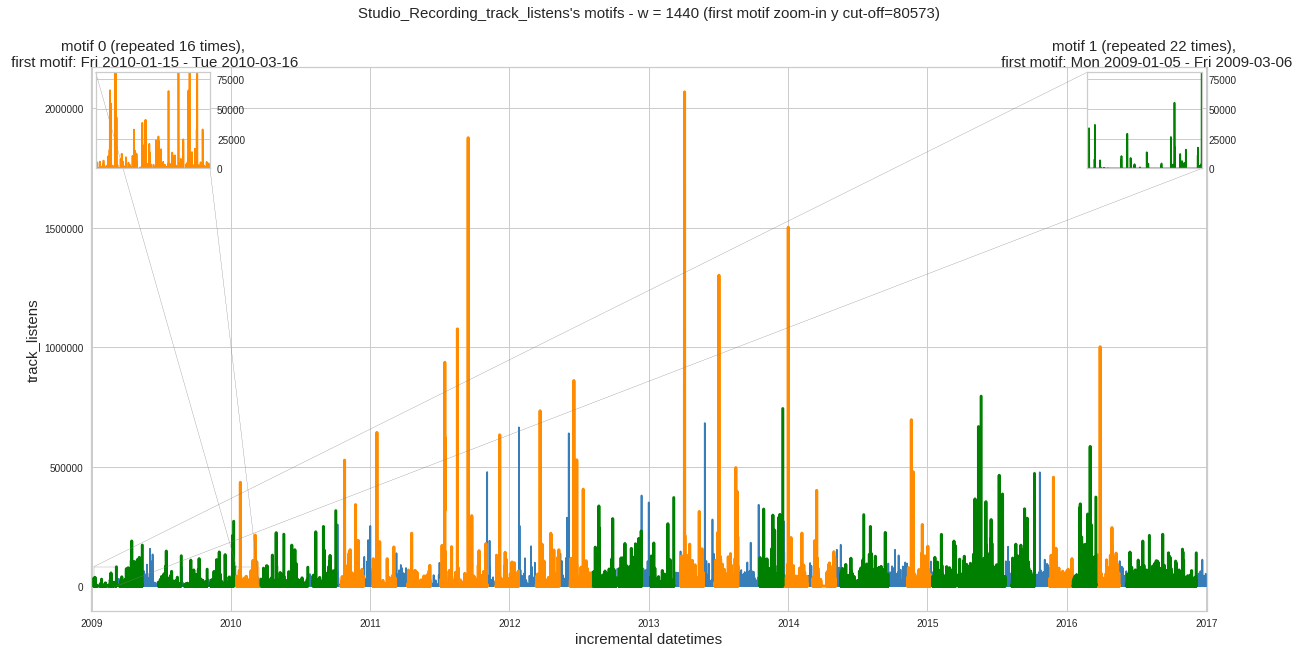

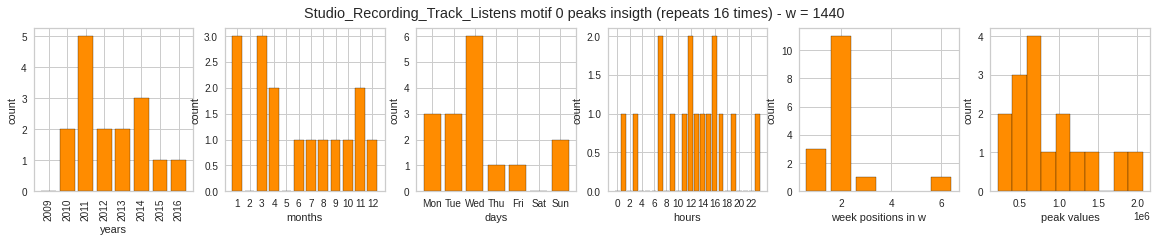


-----------------------------------------------------------------------------------------------------



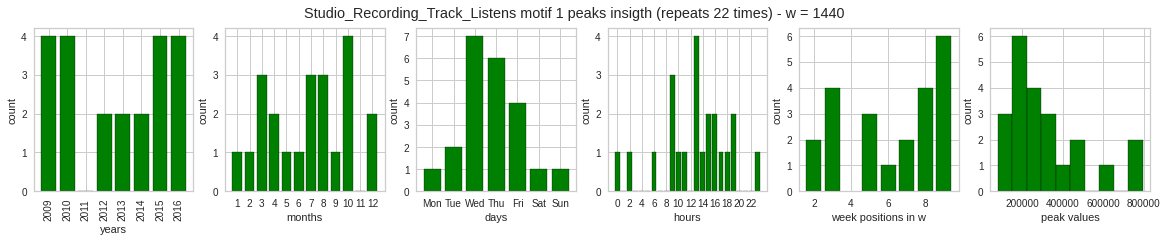


-----------------------------------------------------------------------------------------------------



In [41]:
ts = studio_ts
name = studio_key
key, w = windows[3][0], windows[3][1]
mo = studio_motifs[key][0]
plot_zoom_in_motifs(ts, mo, w, name, locs=[2, 1], zoom=5, y2=80573, motif_or_anomaly_flag="motif", peak_flag="True")

motifs_max_x [321480, 213301, 108604, 29048, 142816]


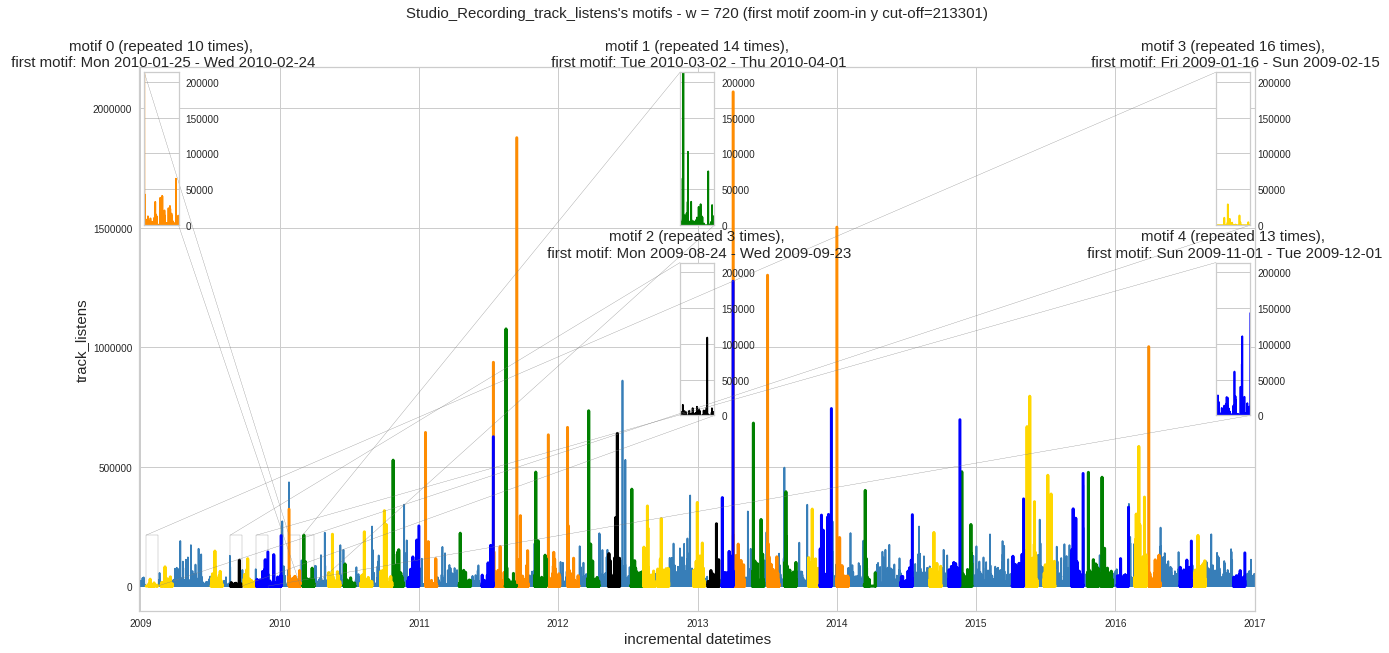

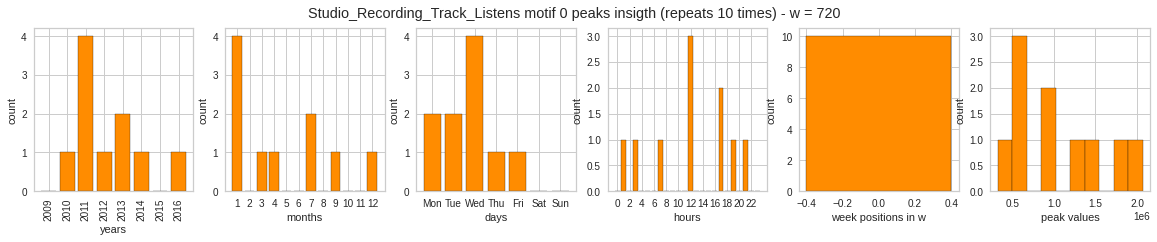


-----------------------------------------------------------------------------------------------------



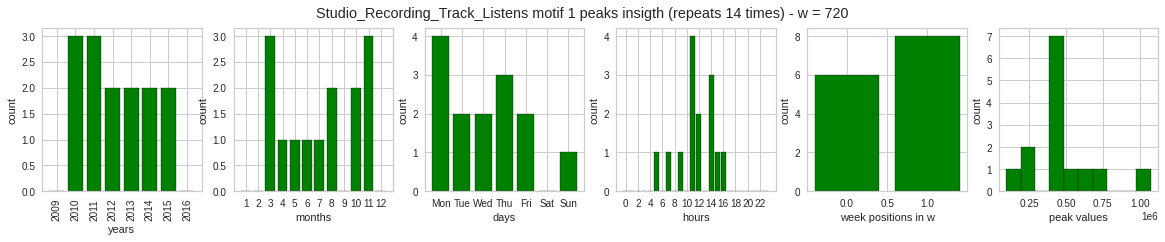


-----------------------------------------------------------------------------------------------------



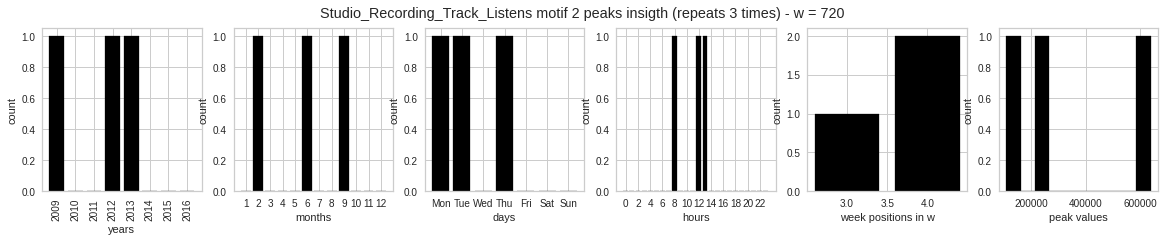


-----------------------------------------------------------------------------------------------------



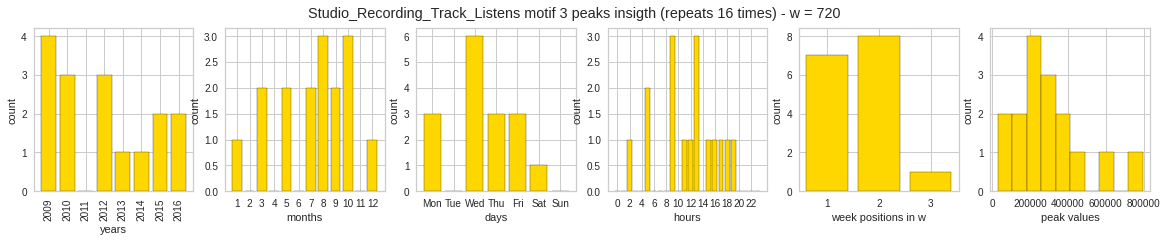


-----------------------------------------------------------------------------------------------------



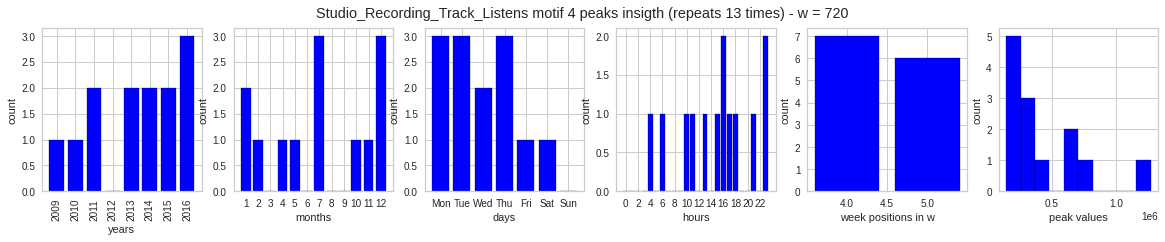


-----------------------------------------------------------------------------------------------------



In [44]:
ts = studio_ts
name = studio_key
key, w = windows[4][0], windows[4][1]
mo = studio_motifs[key][0]
plot_zoom_in_motifs(ts, mo, w, name, locs=[2, 9, 10, 1, 5], zoom=3, y2=213301, motif_or_anomaly_flag="motif", peak_flag=True)

<h6>Live motifs zoom-in</h6>

motifs_max_x [81808]


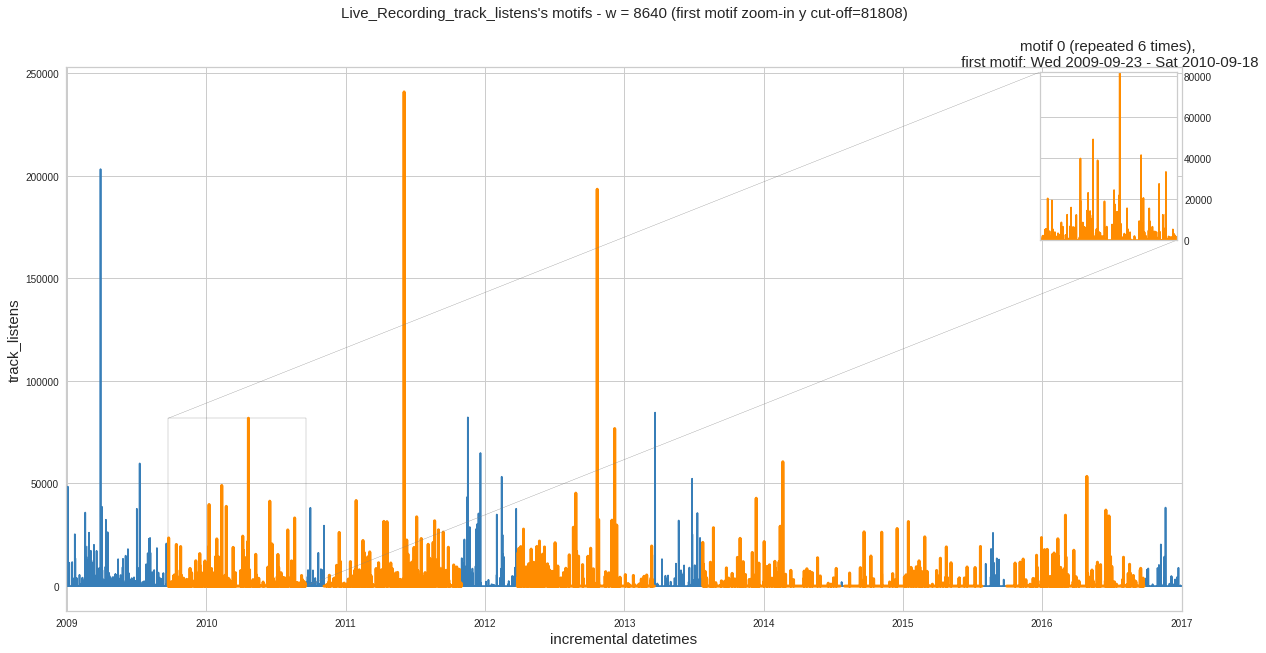

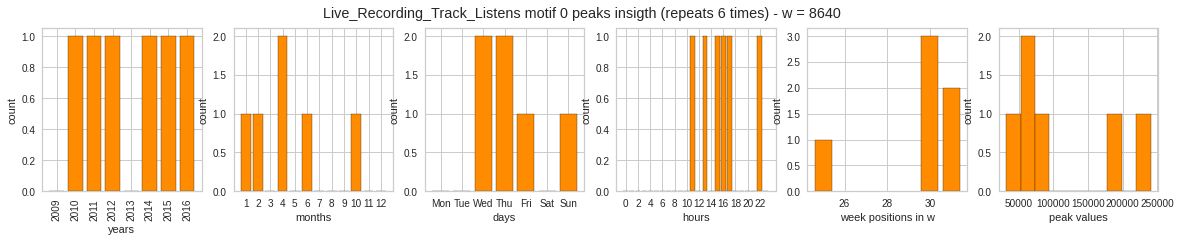


-----------------------------------------------------------------------------------------------------



In [47]:
ts = live_ts
name = live_key
key, w = windows[0][0], windows[0][1]
mo = live_motifs[key][0]
plot_zoom_in_motifs(ts, mo, w, name, locs=[1], zoom=1, y2=81808, motif_or_anomaly_flag="motif", peak_flag=True)

motifs_max_x [81808, 203160]


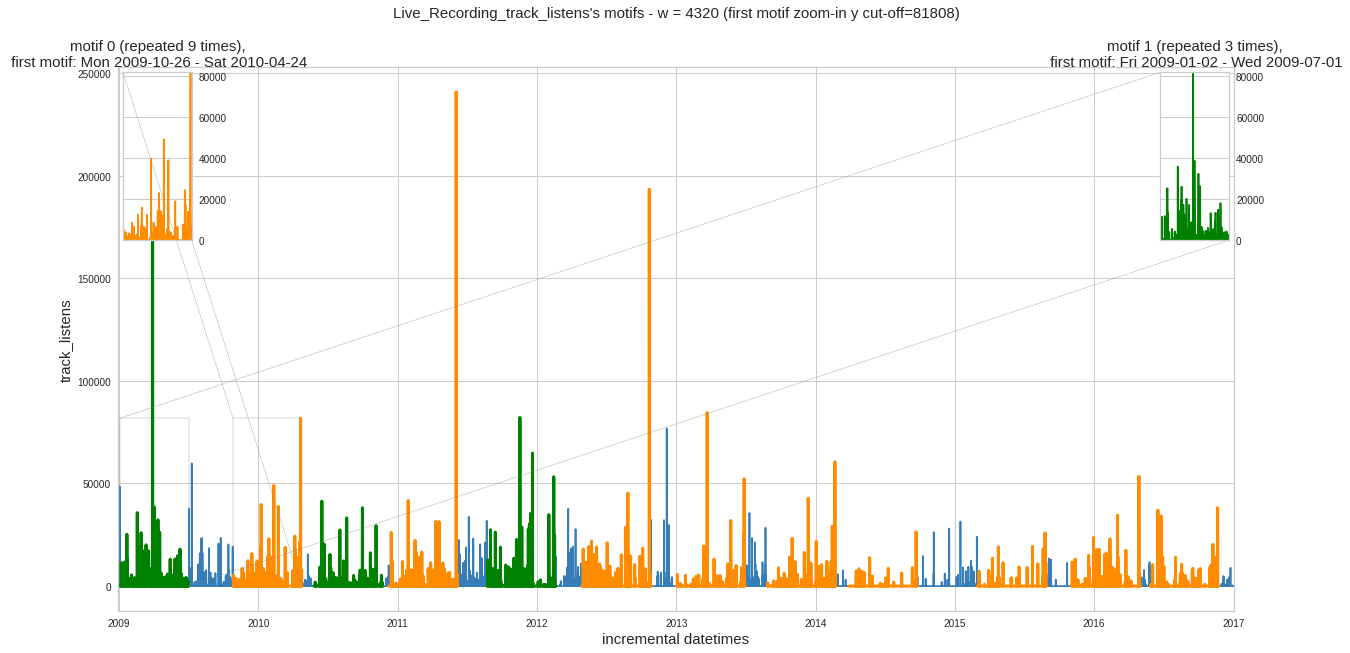

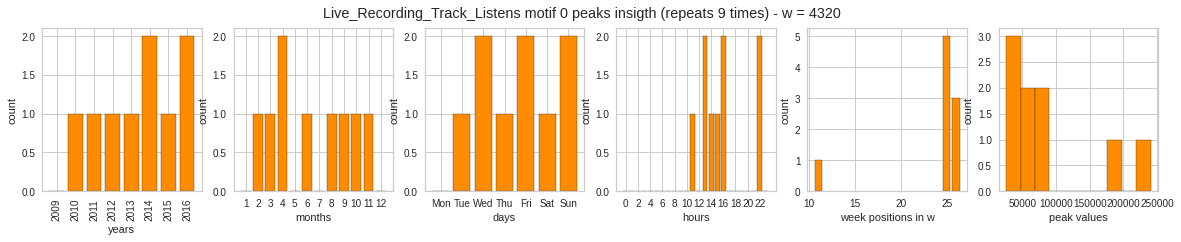


-----------------------------------------------------------------------------------------------------



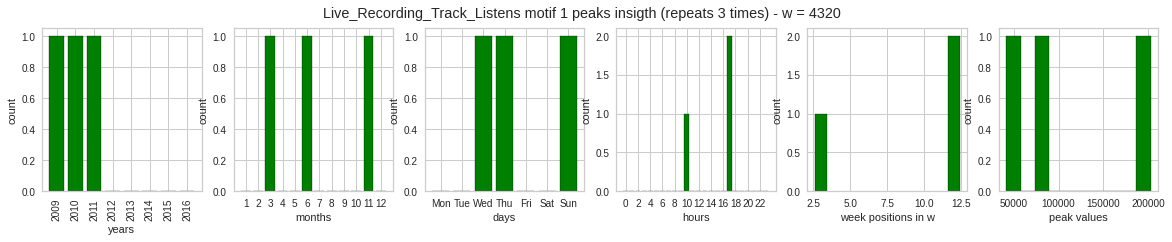


-----------------------------------------------------------------------------------------------------



In [50]:
ts = live_ts
name = live_key
key, w = windows[1][0], windows[1][1]
mo = live_motifs[key][0]
plot_zoom_in_motifs(ts, mo, w, name, locs=[2, 1], zoom=1, y2=81808, motif_or_anomaly_flag="motif", peak_flag=True)

motifs_max_x [203160, 59760, 49038]


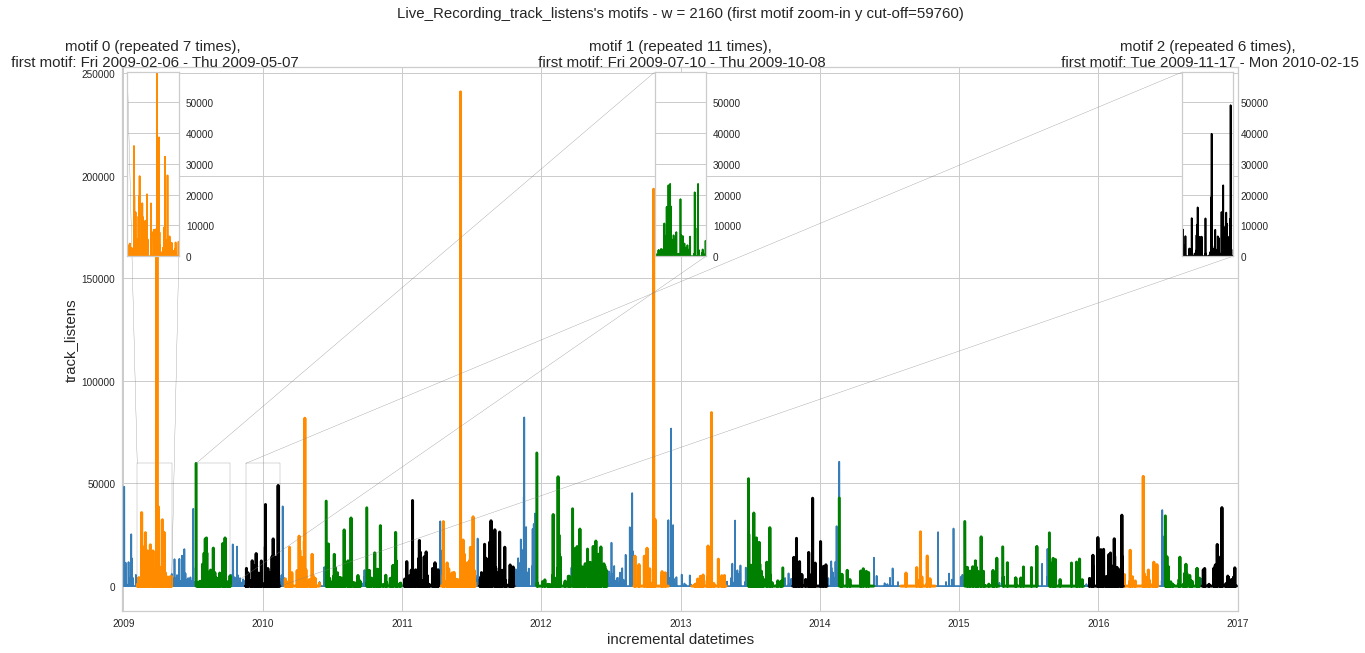

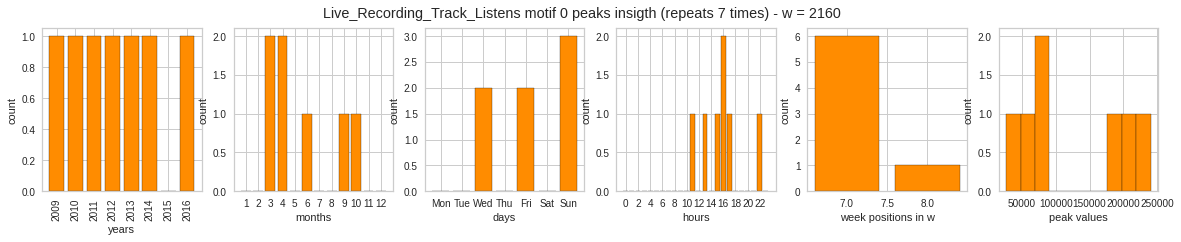


-----------------------------------------------------------------------------------------------------



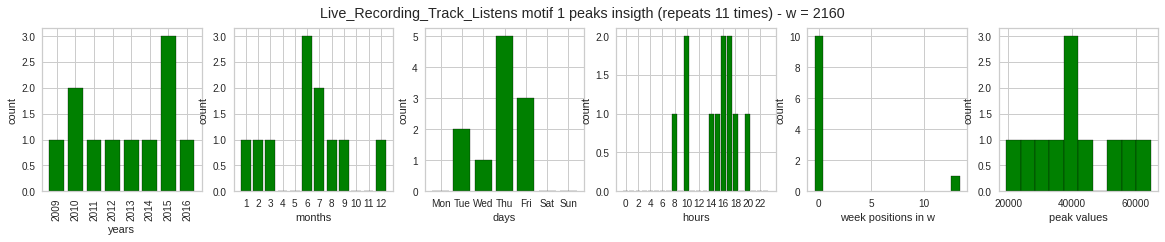


-----------------------------------------------------------------------------------------------------



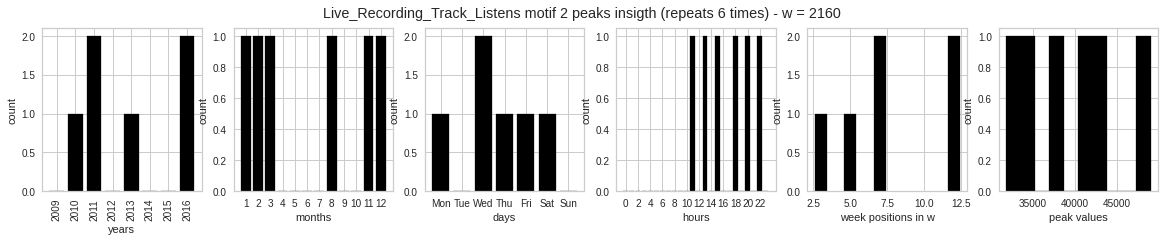


-----------------------------------------------------------------------------------------------------



In [58]:
ts = live_ts
name = live_key
key, w = windows[2][0], windows[2][1]
mo = live_motifs[key][0]
plot_zoom_in_motifs(ts, mo, w, name, locs=[2, 9, 1], zoom=1.5, y2=59760, motif_or_anomaly_flag="motif", peak_flag=True)

motifs_max_x [203160, 8637, 59760, 18016, 41388]


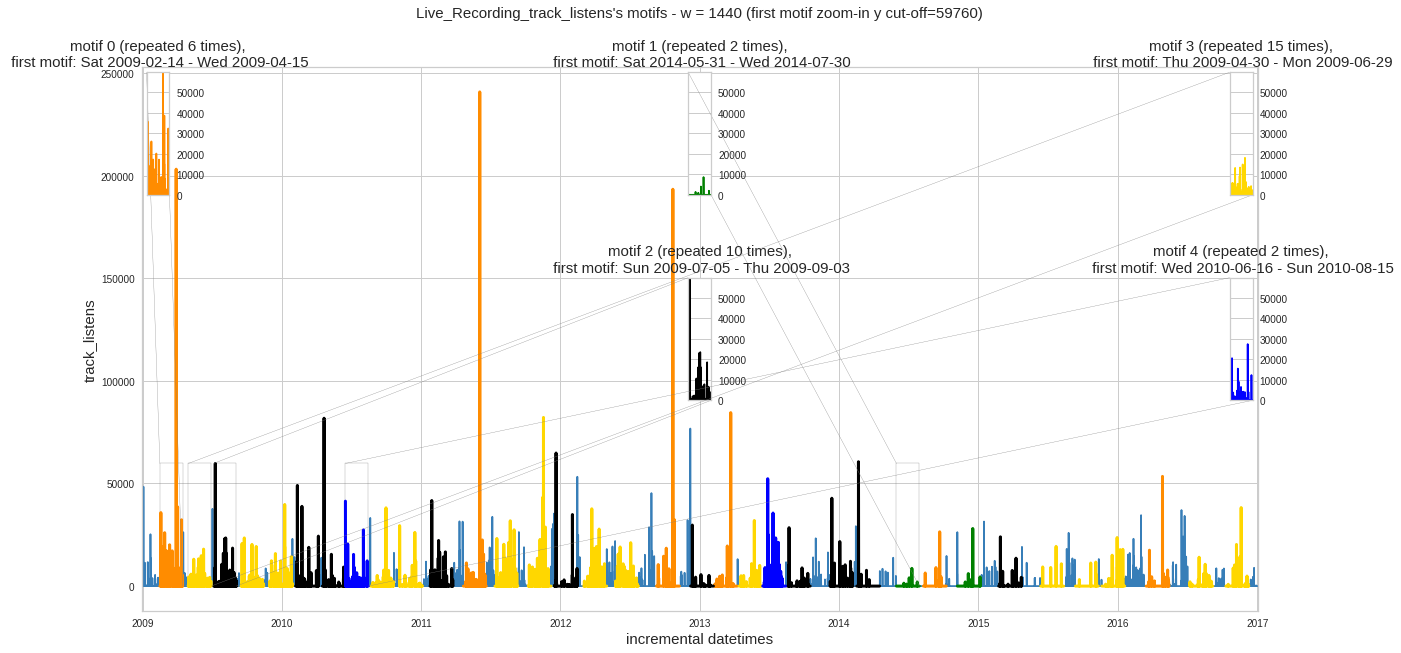

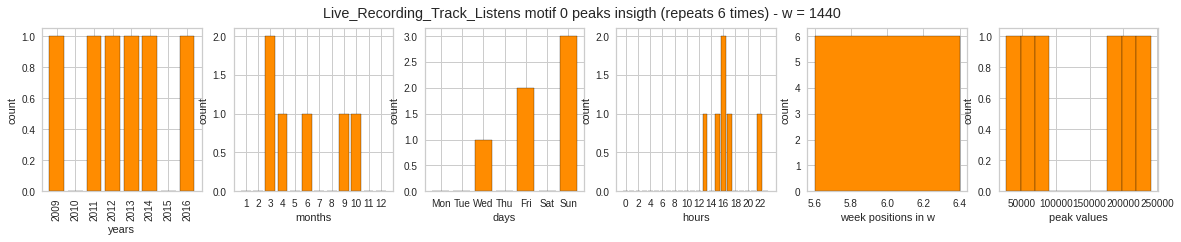


-----------------------------------------------------------------------------------------------------



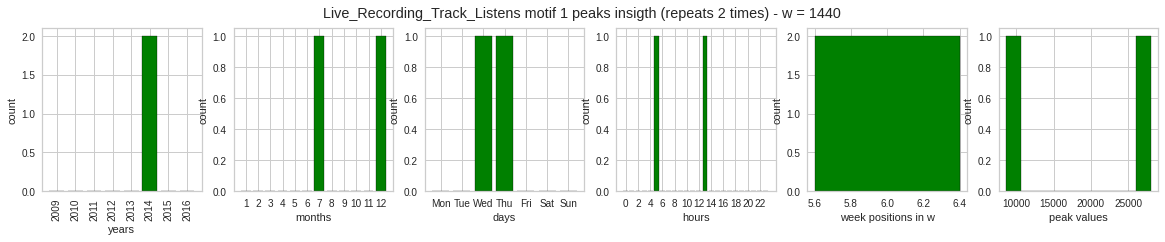


-----------------------------------------------------------------------------------------------------



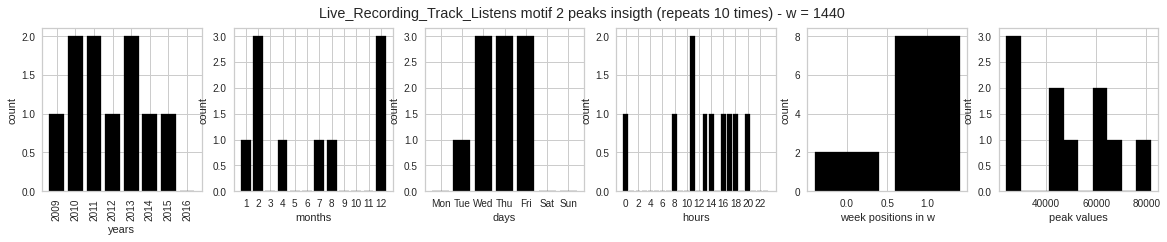


-----------------------------------------------------------------------------------------------------



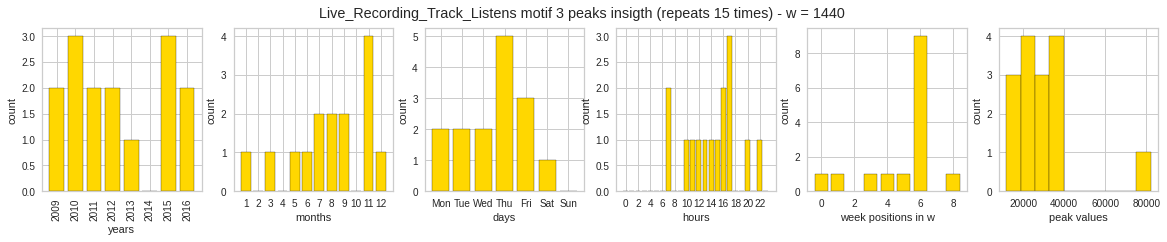


-----------------------------------------------------------------------------------------------------



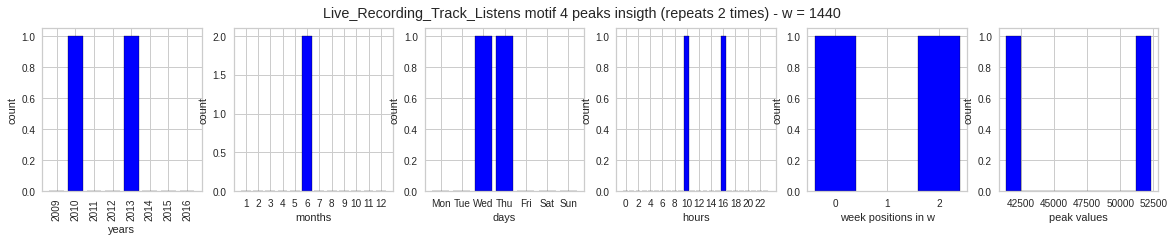


-----------------------------------------------------------------------------------------------------



In [57]:
ts = live_ts
name = live_key
key, w = windows[3][0], windows[3][1]
mo = live_motifs[key][0]
plot_zoom_in_motifs(ts, mo, w, name, locs=[2, 9, 10, 1, 5], zoom=1, y2=59760, motif_or_anomaly_flag="motif", peak_flag=True)

motifs_max_x [3160, 9050, 240814, 203160]


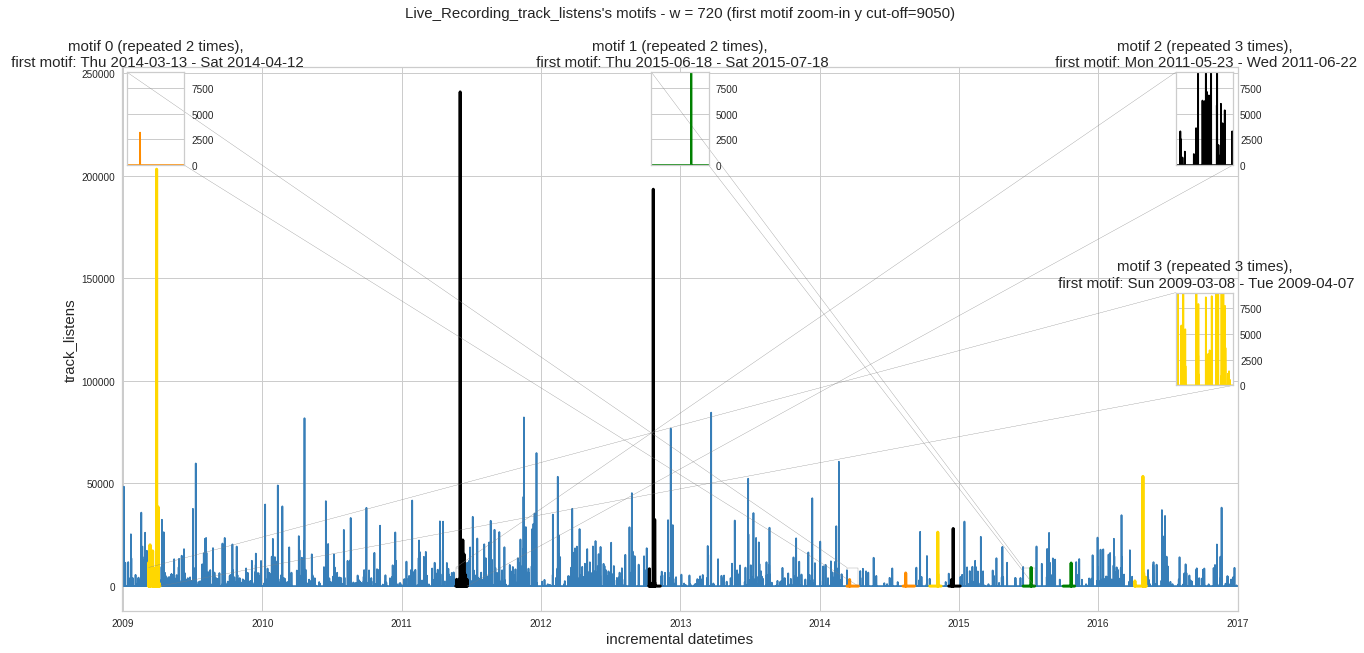

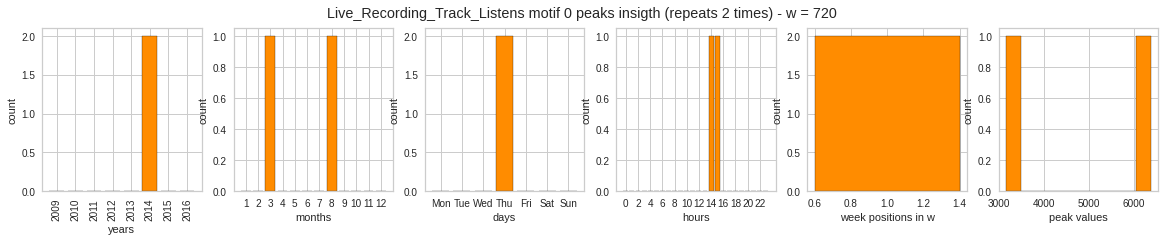


-----------------------------------------------------------------------------------------------------



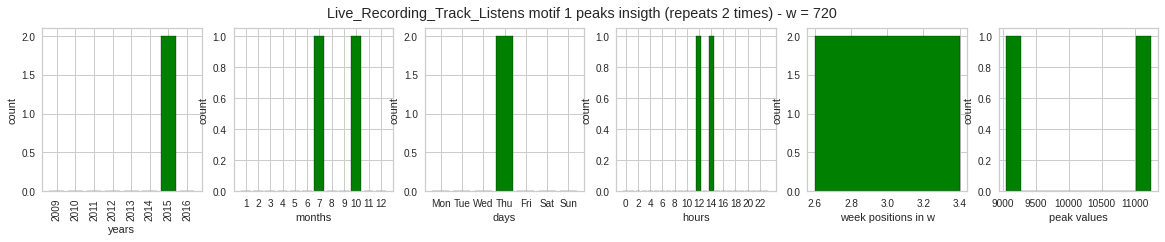


-----------------------------------------------------------------------------------------------------



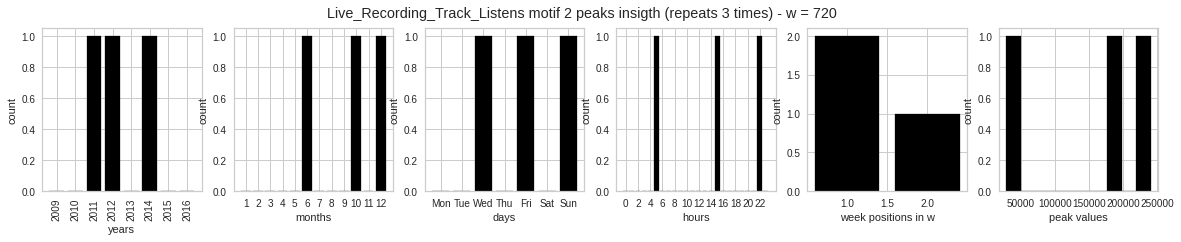


-----------------------------------------------------------------------------------------------------



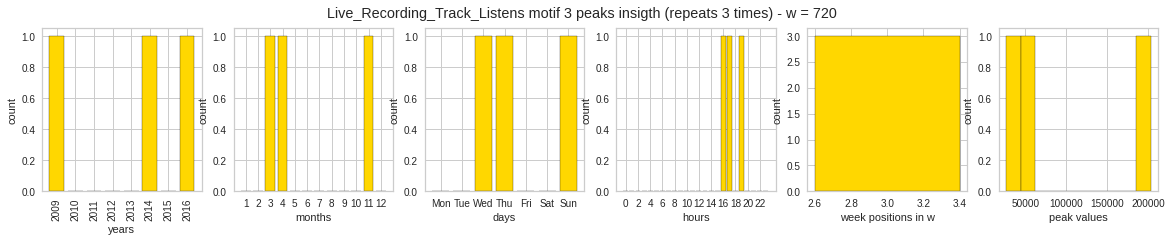


-----------------------------------------------------------------------------------------------------



In [64]:
ts = live_ts
name = live_key
key, w = windows[4][0], windows[4][1]
mo = live_motifs[key][0]
plot_zoom_in_motifs(ts, mo, w, name, locs=[2, 9, 1, 5], zoom=5, y2=9050, motif_or_anomaly_flag="motif", peak_flag=True)

<h6> Studio insight </h6>

In [ ]:
# motifs_insight(interesting_windows, "studio", False, "motif")

In [ ]:
# motifs_insight(interesting_windows, "studio", True, "motif")

<h6>Live insight</h6>

In [ ]:
# motifs_insight(interesting_windows, "live", False, "motif")

In [ ]:
# motifs_insight(interesting_windows, "live", True, "motif")

<h2> Anomaly Discovery </h2>

In [65]:
from matrixprofile.discords import discords

In [66]:
def anomalies_discovery():
    studio_anomalies = {}
    live_anomalies = {}
    for label, window_size in windows:

        key = '%s' % str(label)
        studio_mp, studio_mpi  = studio_profiles[key][0], studio_profiles[key][1]
        live_mp, live_mpi = live_profiles[key][0], live_profiles[key][1]

        # ex_zone = int(np.ceil(window_size / 2))
        ex_zone = window_size
        studio_anoms = discords(studio_mp, ex_zone=ex_zone, k=5)
        live_anoms = discords(live_mp, ex_zone=ex_zone, k=5)

        studio_anomalies[key] = studio_anoms
        live_anomalies[key] =  live_anoms
        
    return studio_anomalies, live_anomalies

<h6> Retrieve top 5 anomalies </h6> 

In [67]:
studio_anomalies, live_anomalies = anomalies_discovery()

<h6>Plot agglomerated anomalies upon original TS</h6<

In [68]:
# plot_agglomerated_motifs(studio_anomalies, live_anomalies, "anomaly")

<h6>Plot individual Studio anomalies upon original TS</h6>

In [69]:
# plot_individual_motifs(studio_anomalies, live_anomalies, "anomaly", "studio")

<h6>Plot individual Live anomalies upon original TS</h6>

In [70]:
# plot_individual_motifs(studio_anomalies, live_anomalies, "anomaly", "live")

<h6>Studio anomalies zoom-in</h6>

motifs_max_x [211076, 794366, 526963, 859896, 695994]


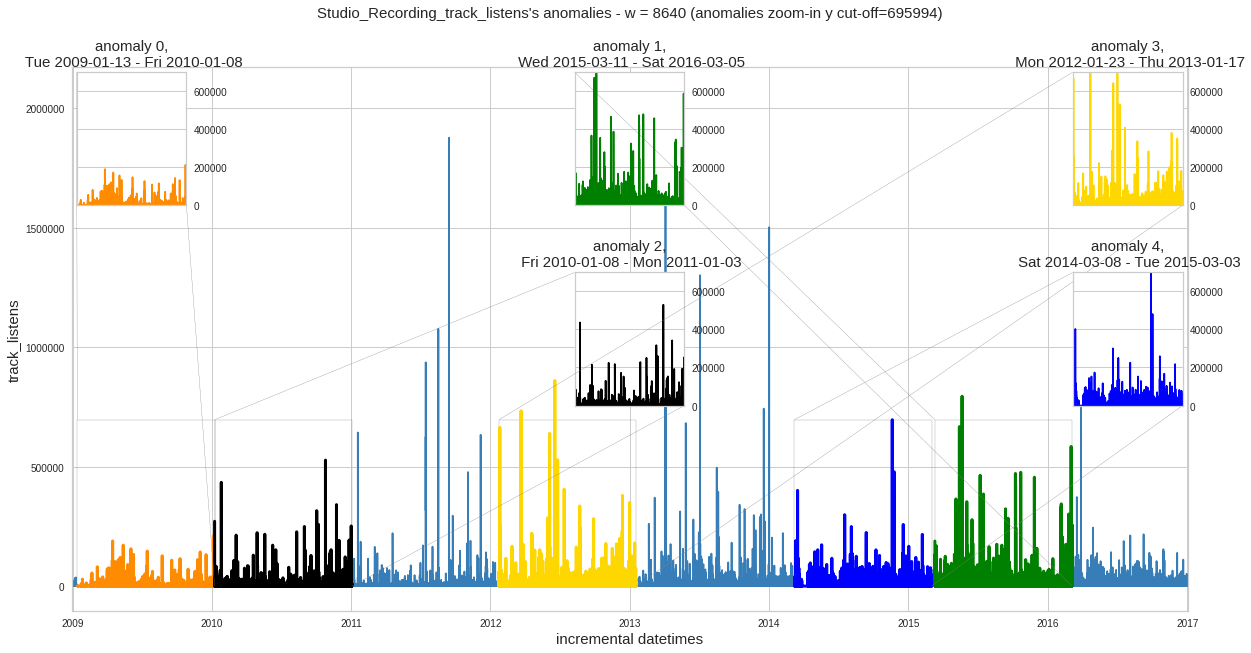

In [72]:
ts = studio_ts
name = studio_key
key, w = windows[0][0], windows[0][1]
mo = studio_anomalies[key]
new_mo = [[m] for m in mo]
plot_zoom_in_motifs(ts, new_mo, w, name, locs=[2, 9, 10, 1, 5], zoom=0.8, y2=695994, motif_or_anomaly_flag="anomaly", peak_flag=False)

motifs_max_x [216638, 476049, 188690, 298639, 249209]


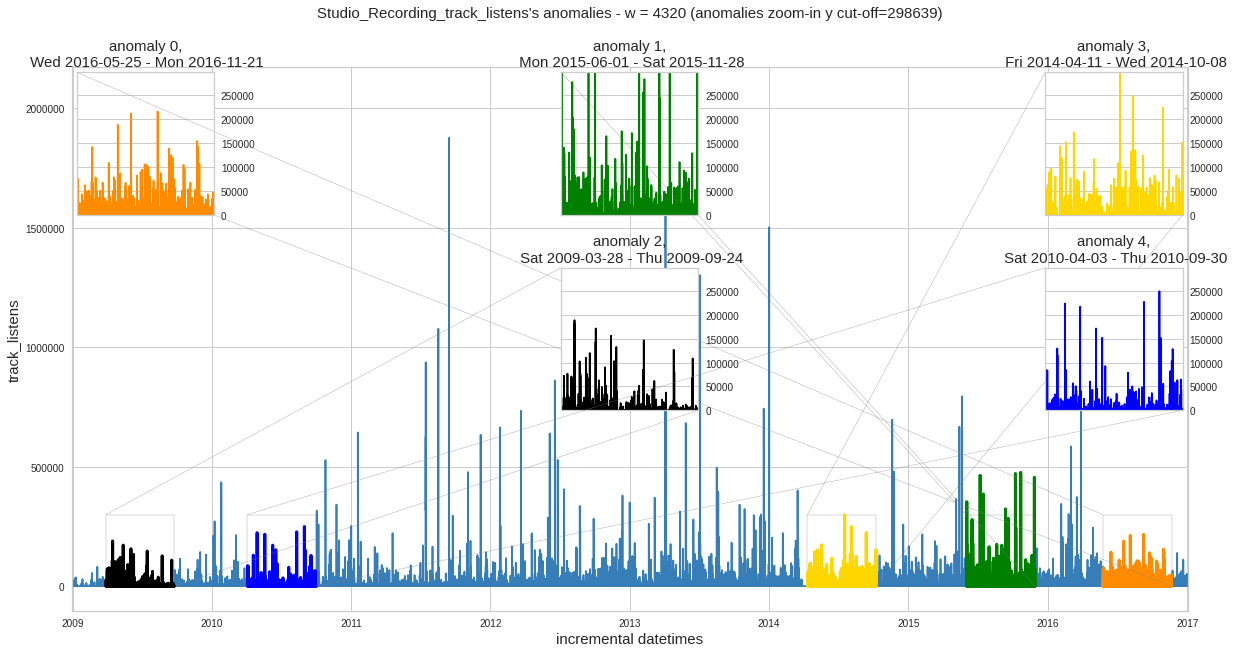

In [80]:
ts = studio_ts
name = studio_key
key, w = windows[1][0], windows[1][1]
mo = studio_anomalies[key]
new_mo = [[m] for m in mo]
plot_zoom_in_motifs(ts, new_mo, w, name, locs=[2, 9, 10, 1, 5], zoom=2, y2=298639, motif_or_anomaly_flag="anomaly", peak_flag=False)

motifs_max_x [154475, 188372, 172801, 216383, 340317]


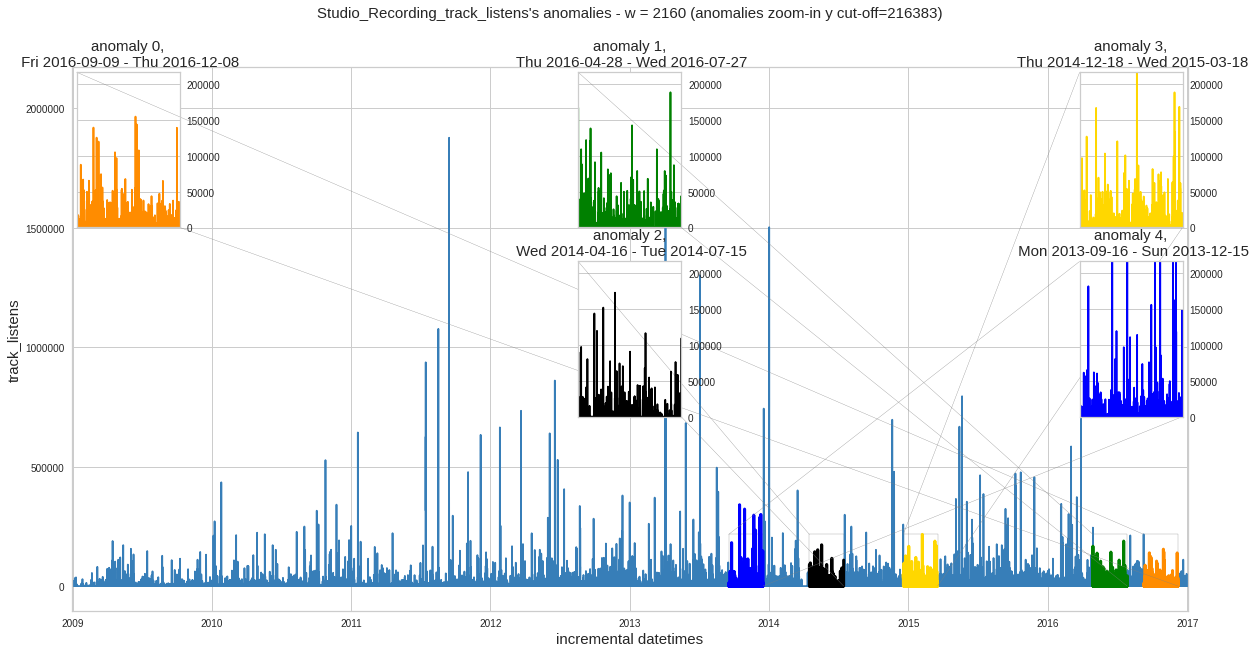

In [78]:
ts = studio_ts
name = studio_key
key, w = windows[2][0], windows[2][1]
mo = studio_anomalies[key]
new_mo = [[m] for m in mo]
plot_zoom_in_motifs(ts, new_mo, w, name, locs=[2, 9, 10, 1, 5], zoom=3, y2=216383, motif_or_anomaly_flag="anomaly", peak_flag=False)

motifs_max_x [199378, 154475, 142238, 151986, 86975]


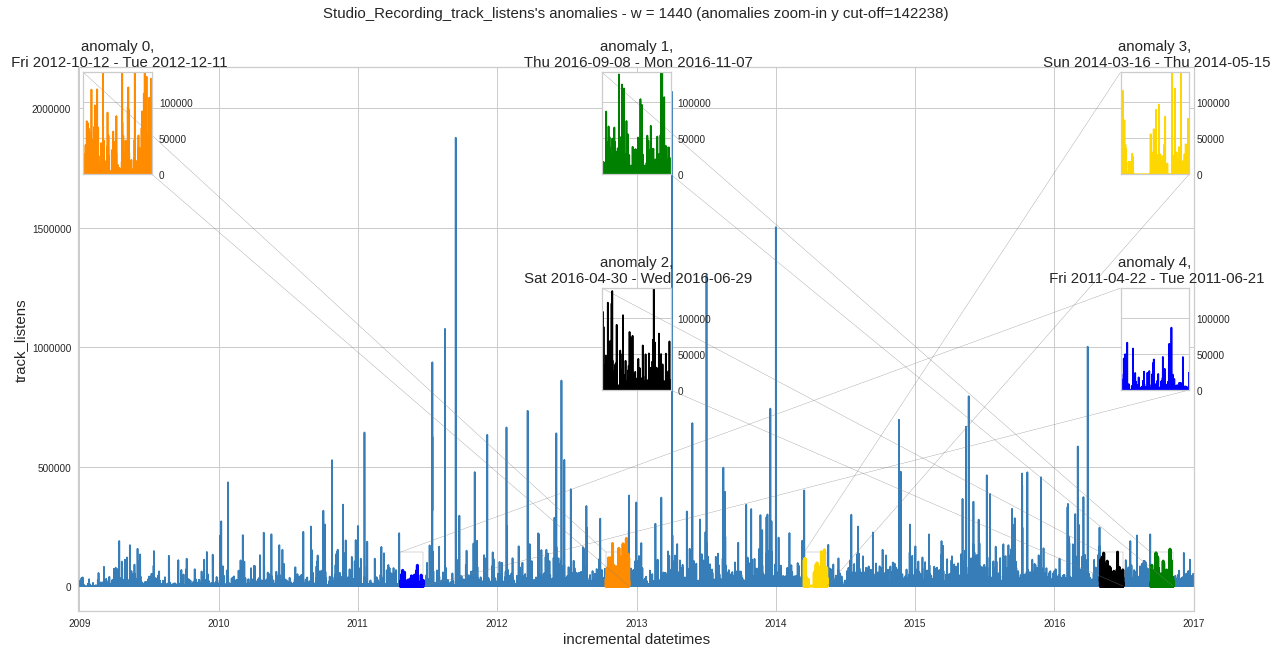

In [83]:
ts = studio_ts
name = studio_key
key, w = windows[3][0], windows[3][1]
mo = studio_anomalies[key]
new_mo = [[m] for m in mo]
plot_zoom_in_motifs(ts, new_mo, w, name, locs=[2, 9, 10, 1, 5], zoom=3, y2=142238, motif_or_anomaly_flag="anomaly", peak_flag=False)

motifs_max_x [98746, 105797, 70691, 98908, 64841]


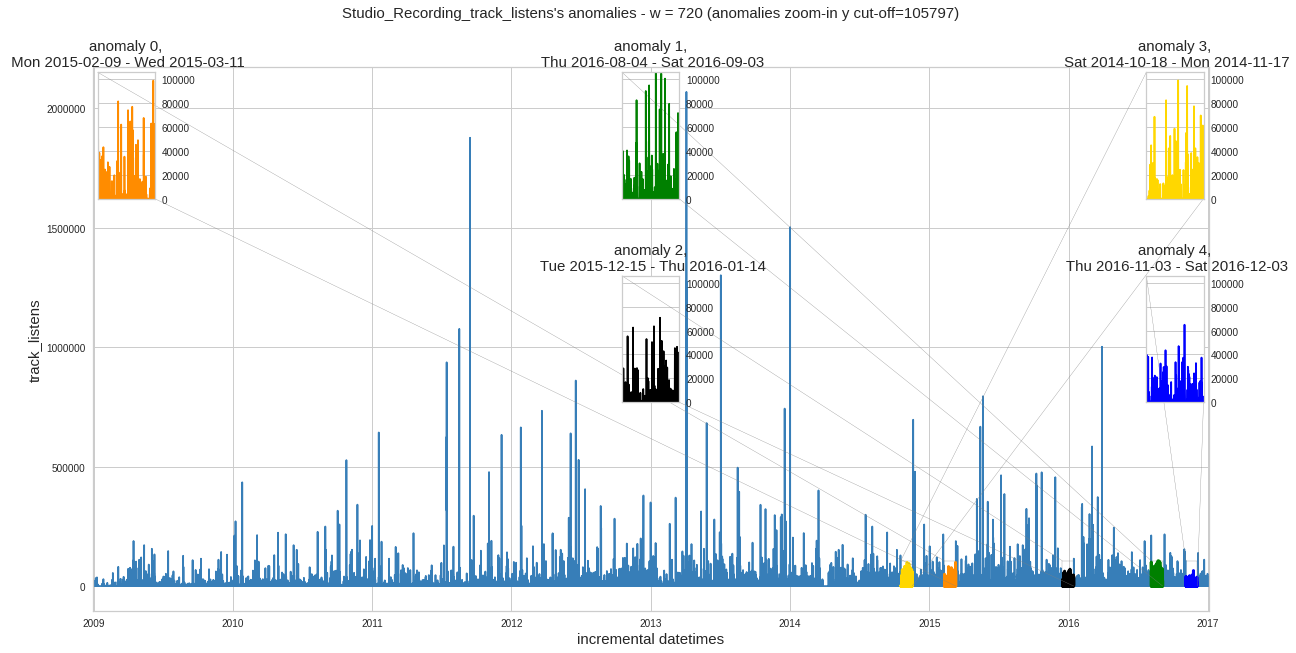

In [86]:
ts = studio_ts
name = studio_key
key, w = windows[4][0], windows[4][1]
mo = studio_anomalies[key]
new_mo = [[m] for m in mo]
plot_zoom_in_motifs(ts, new_mo, w, name, locs=[2, 9, 10, 1, 5], zoom=5, y2=105797, motif_or_anomaly_flag="anomaly", peak_flag=False)

<h6>Live anomalies zoom-in</h6>

motifs_max_x [41695, 25935, 59760, 82184, 60591]


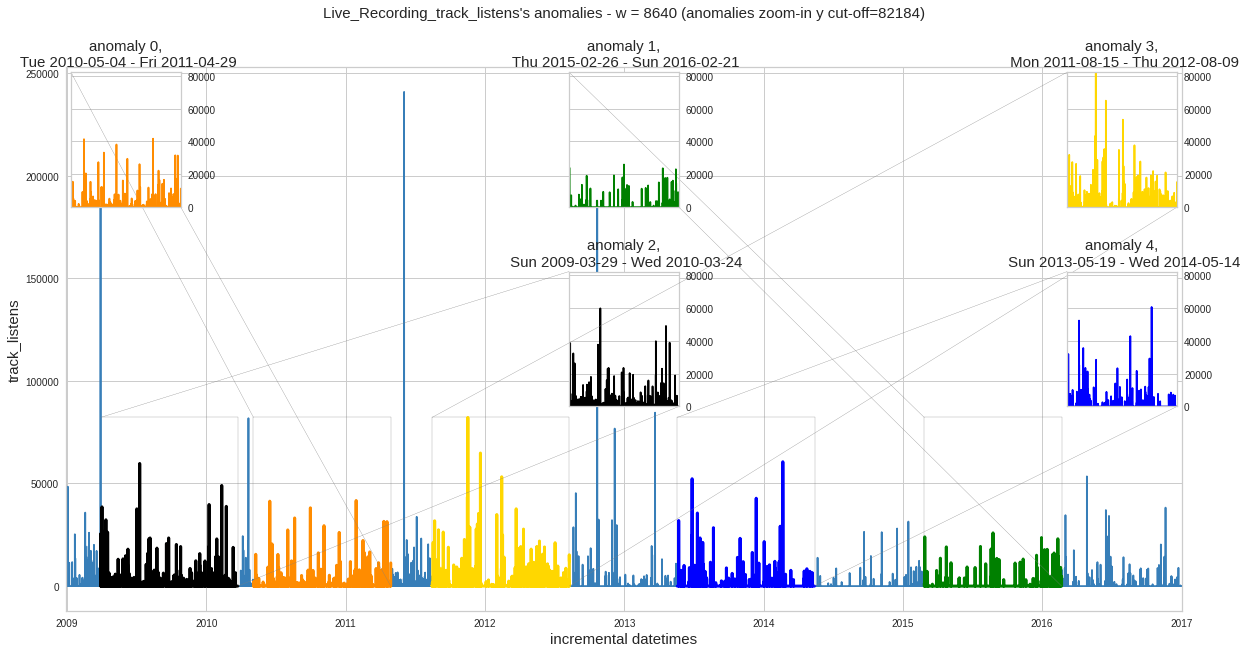

In [92]:
ts = live_ts
name = live_key
key, w = windows[0][0], windows[0][1]
mo = live_anomalies[key]
new_mo = [[m] for m in mo]
plot_zoom_in_motifs(ts, new_mo, w, name, locs=[2, 9, 10, 1, 5], zoom=0.8, y2=82184, motif_or_anomaly_flag="anomaly", peak_flag=False)

motifs_max_x [23470, 25935, 37663, 41388, 24000]


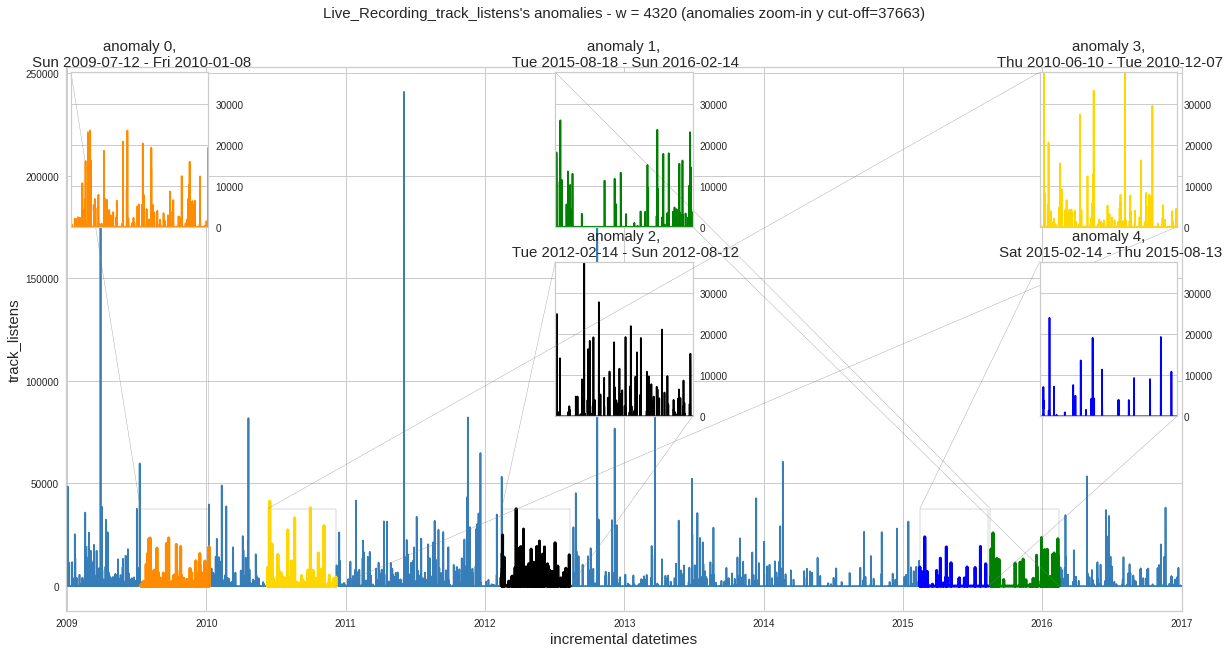

In [94]:
ts = live_ts
name = live_key
key, w = windows[1][0], windows[1][1]
mo = live_anomalies[key]
new_mo = [[m] for m in mo]
plot_zoom_in_motifs(ts, new_mo, w, name, locs=[2, 9, 10, 1, 5], zoom=2, y2=37663, motif_or_anomaly_flag="anomaly", peak_flag=False)

motifs_max_x [21962, 10646, 23470, 5593, 33754]


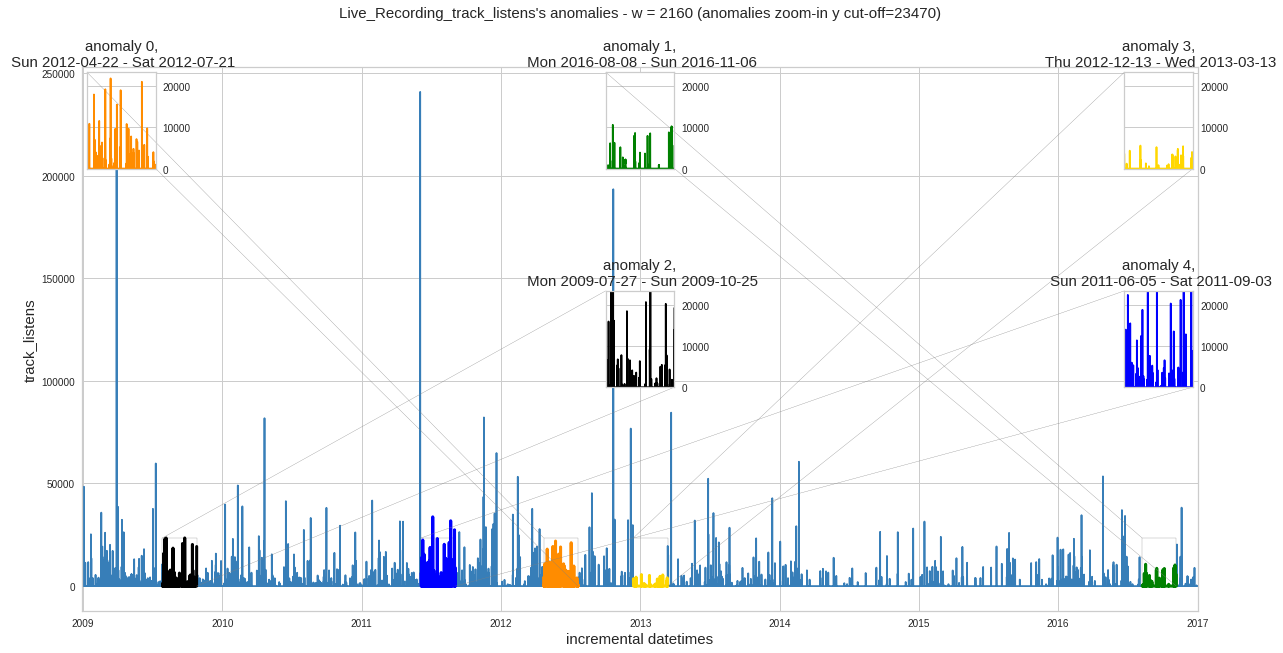

In [98]:
ts = live_ts
name = live_key
key, w = windows[2][0], windows[2][1]
mo = live_anomalies[key]
new_mo = [[m] for m in mo]
plot_zoom_in_motifs(ts, new_mo, w, name, locs=[2, 9, 10, 1, 5], zoom=2, y2=23470, motif_or_anomaly_flag="anomaly", peak_flag=False)

motifs_max_x [21962, 5430, 23470, 18016, 8670]


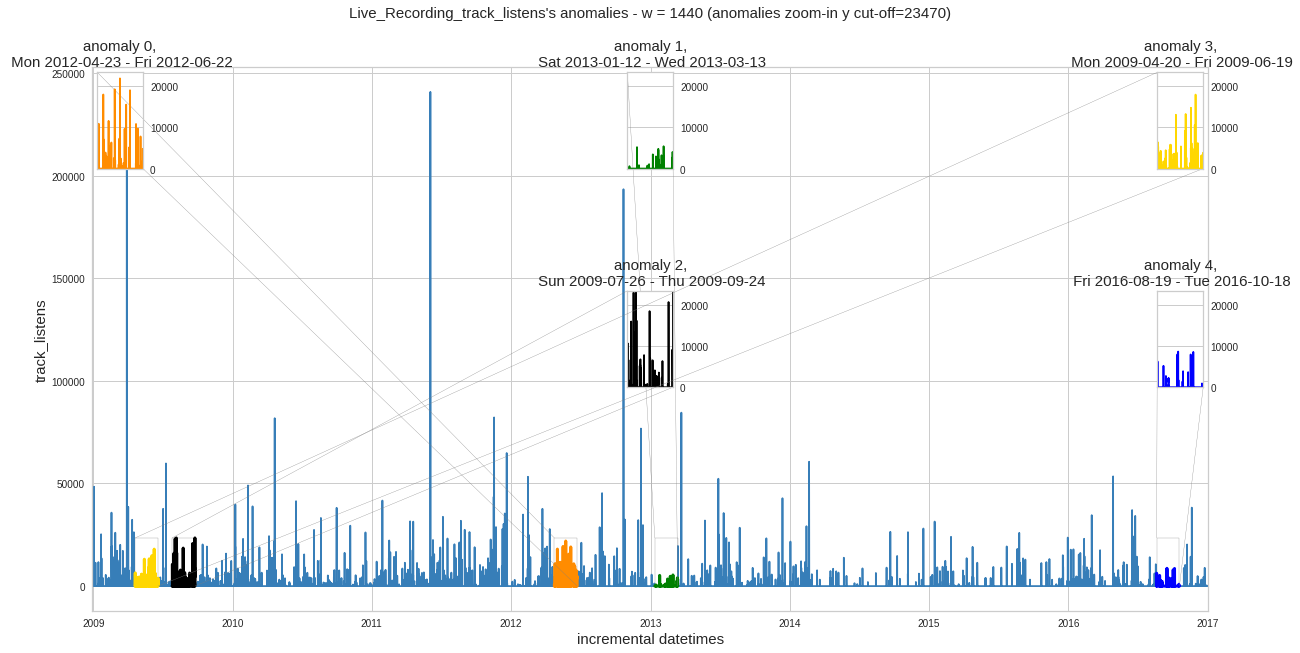

In [99]:
ts = live_ts
name = live_key
key, w = windows[3][0], windows[3][1]
mo = live_anomalies[key]
new_mo = [[m] for m in mo]
plot_zoom_in_motifs(ts, new_mo, w, name, locs=[2, 9, 10, 1, 5], zoom=2, y2=23470, motif_or_anomaly_flag="anomaly", peak_flag=False)

motifs_max_x [20116, 4899, 22476, 13287, 10971]


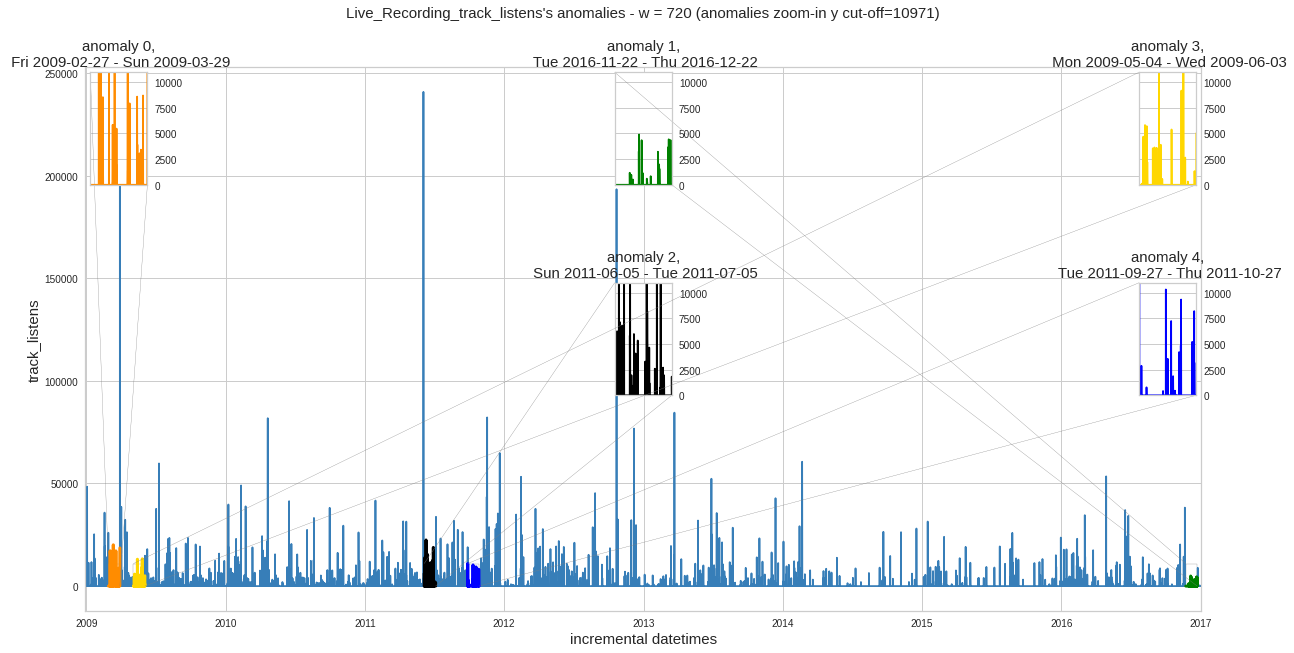

In [100]:
ts = live_ts
name = live_key
key, w = windows[4][0], windows[4][1]
mo = live_anomalies[key]
new_mo = [[m] for m in mo]
plot_zoom_in_motifs(ts, new_mo, w, name, locs=[2, 9, 10, 1, 5], zoom=5, y2=10971, motif_or_anomaly_flag="anomaly", peak_flag=False)